In [126]:
import matplotlib.dates as mdates
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.feature_selection import SelectKBest, chi2, f_regression, mutual_info_regression


In [2]:
usd_eur_df = pd.read_csv('USD_EUR Historical Data.csv')
usd_eur_df

Date   Price    Open    High     Low Vol. Change %
0     12/29/2023  0.9060  0.9041  0.9064  0.9021  NaN    0.23%
1     12/28/2023  0.9039  0.9003  0.9046  0.8976  NaN    0.40%
2     12/27/2023  0.9003  0.9056  0.9068  0.8990  NaN   -0.55%
3     12/26/2023  0.9053  0.9082  0.9084  0.9054  NaN   -0.32%
4     12/25/2023  0.9082  0.9077  0.9097  0.9072  NaN    0.03%
...          ...     ...     ...     ...     ...  ...      ...
1610  10/27/2017  0.8613  0.8583  0.8640  0.8578  NaN    0.35%
1611  10/26/2017  0.8583  0.8465  0.8590  0.8448  NaN    1.38%
1612  10/25/2017  0.8466  0.8501  0.8508  0.8460  NaN   -0.42%
1613  10/24/2017  0.8502  0.8511  0.8518  0.8479  NaN   -0.11%
1614  10/23/2017  0.8511  0.8495  0.8529  0.8491  NaN    0.31%

[1615 rows x 7 columns]

In [3]:
usd_eur_df = usd_eur_df.drop(columns=['Open', 'High', 'Low', 'Vol.', 'Change %'])
usd_eur_df = usd_eur_df.rename(columns={'Date': 'time','Price': 'usd_eur'})

usd_eur_df['time'] = pd.to_datetime(usd_eur_df['time'], errors='coerce')
usd_eur_df = usd_eur_df.set_index('time').resample('H').ffill()


#Adjusting the range, reindex and forward fill the missing values 
adjusted_date_range = pd.date_range(start='2017-10-23 00:00:00', end='2023-12-31 23:59:59', freq='H')
usd_eur_df = usd_eur_df.reindex(adjusted_date_range).rename_axis('time').reset_index()
usd_eur_df['usd_eur'].fillna(method='ffill', inplace=True)

usd_eur_df

time  usd_eur
0     2017-10-23 00:00:00   0.8511
1     2017-10-23 01:00:00   0.8511
2     2017-10-23 02:00:00   0.8511
3     2017-10-23 03:00:00   0.8511
4     2017-10-23 04:00:00   0.8511
...                   ...      ...
54259 2023-12-31 19:00:00   0.9060
54260 2023-12-31 20:00:00   0.9060
54261 2023-12-31 21:00:00   0.9060
54262 2023-12-31 22:00:00   0.9060
54263 2023-12-31 23:00:00   0.9060

[54264 rows x 2 columns]

In [4]:
# check missing values
usd_eur_df.isnull().sum()

time       0
usd_eur    0
dtype: int64

## Oil dataset

In [5]:
oil_df = pd.read_csv('Brent_Spot_Price_FOB.csv')
oil_df

Day  Europe Brent Spot Price FOB  Dollars per Barrel
0     12/29/2023                                            77.69
1     12/28/2023                                            79.04
2     12/27/2023                                            80.97
3     12/22/2023                                            80.23
4     12/21/2023                                            80.73
...          ...                                              ...
1563  10/27/2017                                            60.15
1564  10/26/2017                                            58.75
1565  10/25/2017                                            58.45
1566  10/24/2017                                            57.84
1567  10/23/2017                                            57.69

[1568 rows x 2 columns]

In [6]:
#rename the columns
oil_df = oil_df.rename(columns={'Europe Brent Spot Price FOB  Dollars per Barrel': 'oil_price', 'Day': 'time'})

In [7]:
oil_df

time  oil_price
0     12/29/2023      77.69
1     12/28/2023      79.04
2     12/27/2023      80.97
3     12/22/2023      80.23
4     12/21/2023      80.73
...          ...        ...
1563  10/27/2017      60.15
1564  10/26/2017      58.75
1565  10/25/2017      58.45
1566  10/24/2017      57.84
1567  10/23/2017      57.69

[1568 rows x 2 columns]

In [8]:
oil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1568 entries, 0 to 1567
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       1568 non-null   object 
 1   oil_price  1568 non-null   float64
dtypes: float64(1), object(1)
memory usage: 24.6+ KB


In [9]:
# adjusting the range to hourly frequency
full_date_range = pd.date_range(start='2017-10-23 00:00:00', end='2023-12-31 23:59:59', freq='H')

# Convert time column to datetime
oil_df['time'] = pd.to_datetime(oil_df['time'])

# Set the time column as the index, resample to hourly frequency and reset the index
oil_df = oil_df.set_index('time')
oil_df = oil_df.reindex(full_date_range).rename_axis('time').reset_index()

# Forward fill the missing values
oil_df['oil_price'].fillna(method='ffill', inplace=True)
oil_df


time  oil_price
0     2017-10-23 00:00:00      57.69
1     2017-10-23 01:00:00      57.69
2     2017-10-23 02:00:00      57.69
3     2017-10-23 03:00:00      57.69
4     2017-10-23 04:00:00      57.69
...                   ...        ...
54259 2023-12-31 19:00:00      77.69
54260 2023-12-31 20:00:00      77.69
54261 2023-12-31 21:00:00      77.69
54262 2023-12-31 22:00:00      77.69
54263 2023-12-31 23:00:00      77.69

[54264 rows x 2 columns]

In [10]:
oil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54264 entries, 0 to 54263
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time       54264 non-null  datetime64[ns]
 1   oil_price  54264 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 848.0 KB


In [11]:
# check missing values
oil_df.isnull().sum()

time         0
oil_price    0
dtype: int64

In [12]:
# Merging the oil dataset with the usd_eur dataset
oil_df = oil_df.merge(usd_eur_df[['time', 'usd_eur']], on='time', how='left')
oil_df

time  oil_price  usd_eur
0     2017-10-23 00:00:00      57.69   0.8511
1     2017-10-23 01:00:00      57.69   0.8511
2     2017-10-23 02:00:00      57.69   0.8511
3     2017-10-23 03:00:00      57.69   0.8511
4     2017-10-23 04:00:00      57.69   0.8511
...                   ...        ...      ...
54259 2023-12-31 19:00:00      77.69   0.9060
54260 2023-12-31 20:00:00      77.69   0.9060
54261 2023-12-31 21:00:00      77.69   0.9060
54262 2023-12-31 22:00:00      77.69   0.9060
54263 2023-12-31 23:00:00      77.69   0.9060

[54264 rows x 3 columns]

In [13]:
# Convert the oil price to euro based on the historical usd_eur exchange rate
oil_df['oil_price_euro'] = oil_df['oil_price'] * oil_df['usd_eur']
oil_df

time  oil_price  usd_eur  oil_price_euro
0     2017-10-23 00:00:00      57.69   0.8511       49.099959
1     2017-10-23 01:00:00      57.69   0.8511       49.099959
2     2017-10-23 02:00:00      57.69   0.8511       49.099959
3     2017-10-23 03:00:00      57.69   0.8511       49.099959
4     2017-10-23 04:00:00      57.69   0.8511       49.099959
...                   ...        ...      ...             ...
54259 2023-12-31 19:00:00      77.69   0.9060       70.387140
54260 2023-12-31 20:00:00      77.69   0.9060       70.387140
54261 2023-12-31 21:00:00      77.69   0.9060       70.387140
54262 2023-12-31 22:00:00      77.69   0.9060       70.387140
54263 2023-12-31 23:00:00      77.69   0.9060       70.387140

[54264 rows x 4 columns]

In [14]:
# drop the oil_price and usd_eur columns
oil_df = oil_df.drop(columns=['oil_price', 'usd_eur'])
oil_df

time  oil_price_euro
0     2017-10-23 00:00:00       49.099959
1     2017-10-23 01:00:00       49.099959
2     2017-10-23 02:00:00       49.099959
3     2017-10-23 03:00:00       49.099959
4     2017-10-23 04:00:00       49.099959
...                   ...             ...
54259 2023-12-31 19:00:00       70.387140
54260 2023-12-31 20:00:00       70.387140
54261 2023-12-31 21:00:00       70.387140
54262 2023-12-31 22:00:00       70.387140
54263 2023-12-31 23:00:00       70.387140

[54264 rows x 2 columns]

## Coal dataset

In [15]:
coal_df = pd.read_csv('Coal_12_29_23-01_02_15 (1).csv')
coal_df

Open   Price    High    Low  Volume      Date
0       0.00  108.30    0.00    0.0     NaN  12/29/23
1       0.00  117.25    0.00    0.0     NaN  12/28/23
2     118.95  117.50  118.95  118.0     NaN  12/27/23
3       0.00  113.50    0.00    0.0     NaN  12/26/23
4     117.00  116.00  117.00  117.0     NaN  12/22/23
...      ...     ...     ...    ...     ...       ...
2290    0.00   60.60    0.00    0.0     NaN  01/08/15
2291    0.00   60.85    0.00    0.0     NaN  01/07/15
2292    0.00   62.70    0.00    0.0     NaN  01/06/15
2293    0.00   63.75    0.00    0.0     NaN  01/05/15
2294    0.00   65.50    0.00    0.0     NaN  01/02/15

[2295 rows x 6 columns]

In [16]:
# Removing the columns that are not needed and renaming the columns
coal_df = coal_df.drop(columns=['Open', 'High', 'Low', 'Volume'])
coal_df = coal_df.rename(columns={'Date': 'time'})
coal_df

Price      time
0     108.30  12/29/23
1     117.25  12/28/23
2     117.50  12/27/23
3     113.50  12/26/23
4     116.00  12/22/23
...      ...       ...
2290   60.60  01/08/15
2291   60.85  01/07/15
2292   62.70  01/06/15
2293   63.75  01/05/15
2294   65.50  01/02/15

[2295 rows x 2 columns]

In [17]:
# adjusting the range to hourly frequency
full_date_range = pd.date_range(start='2017-10-23 00:00:00', end='2023-12-31 23:59:59', freq='H')

# Convert time column to datetime
coal_df['time'] = pd.to_datetime(coal_df['time'])

# Set the time column as the index, resample to hourly frequency and reset the index
coal_df = coal_df.set_index('time')
coal_df = coal_df.reindex(full_date_range).rename_axis('time').reset_index()

# Forward fill the missing values
coal_df['Price'].fillna(method='ffill', inplace=True)
coal_df

C:\Users\pep\AppData\Local\Temp\ipykernel_23836\2397228193.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  coal_df['time'] = pd.to_datetime(coal_df['time'])


time  Price
0     2017-10-23 00:00:00   91.8
1     2017-10-23 01:00:00   91.8
2     2017-10-23 02:00:00   91.8
3     2017-10-23 03:00:00   91.8
4     2017-10-23 04:00:00   91.8
...                   ...    ...
54259 2023-12-31 19:00:00  108.3
54260 2023-12-31 20:00:00  108.3
54261 2023-12-31 21:00:00  108.3
54262 2023-12-31 22:00:00  108.3
54263 2023-12-31 23:00:00  108.3

[54264 rows x 2 columns]

In [18]:
coal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54264 entries, 0 to 54263
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    54264 non-null  datetime64[ns]
 1   Price   54264 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 848.0 KB


In [19]:
coal_df.isnull().sum()

time     0
Price    0
dtype: int64

In [20]:
coal_df = coal_df.merge(usd_eur_df[['time', 'usd_eur']], on='time', how='left')
coal_df

time  Price  usd_eur
0     2017-10-23 00:00:00   91.8   0.8511
1     2017-10-23 01:00:00   91.8   0.8511
2     2017-10-23 02:00:00   91.8   0.8511
3     2017-10-23 03:00:00   91.8   0.8511
4     2017-10-23 04:00:00   91.8   0.8511
...                   ...    ...      ...
54259 2023-12-31 19:00:00  108.3   0.9060
54260 2023-12-31 20:00:00  108.3   0.9060
54261 2023-12-31 21:00:00  108.3   0.9060
54262 2023-12-31 22:00:00  108.3   0.9060
54263 2023-12-31 23:00:00  108.3   0.9060

[54264 rows x 3 columns]

In [21]:
# Convert the oil price to euro based on the historical usd_eur exchange rate
coal_df['coal_price_euro'] = coal_df['Price'] * coal_df['usd_eur']

In [22]:
# drop the Price and usd_eur columns
coal_df = coal_df.drop(columns=['Price', 'usd_eur'])
coal_df

time  coal_price_euro
0     2017-10-23 00:00:00         78.13098
1     2017-10-23 01:00:00         78.13098
2     2017-10-23 02:00:00         78.13098
3     2017-10-23 03:00:00         78.13098
4     2017-10-23 04:00:00         78.13098
...                   ...              ...
54259 2023-12-31 19:00:00         98.11980
54260 2023-12-31 20:00:00         98.11980
54261 2023-12-31 21:00:00         98.11980
54262 2023-12-31 22:00:00         98.11980
54263 2023-12-31 23:00:00         98.11980

[54264 rows x 2 columns]

## Reservoir dataset

In [23]:
#load reservoir data
reservoir_df = pd.read_csv('reservoir_hourly.csv')
reservoir_df

Datetime  Stored_Energy_Value
0      2017-10-23 00:00:00           29621000.0
1      2017-10-23 01:00:00           29621000.0
2      2017-10-23 02:00:00           29621000.0
3      2017-10-23 03:00:00           29621000.0
4      2017-10-23 04:00:00           29621000.0
...                    ...                  ...
54259  2023-12-31 19:00:00           23361204.0
54260  2023-12-31 20:00:00           23361204.0
54261  2023-12-31 21:00:00           23361204.0
54262  2023-12-31 22:00:00           23361204.0
54263  2023-12-31 23:00:00           23361204.0

[54264 rows x 2 columns]

In [24]:
# rename the column
reservoir_df = reservoir_df.rename(columns={'Datetime': 'time'})

In [25]:
# Convert time column to datetime and set it as index
reservoir_df['time'] = pd.to_datetime(reservoir_df['time'], errors='coerce')

reservoir_df = reservoir_df.reset_index()
reservoir_df.drop(columns=['index'], inplace=True)

In [26]:
reservoir_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54264 entries, 0 to 54263
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   time                 54264 non-null  datetime64[ns]
 1   Stored_Energy_Value  54264 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 848.0 KB


In [27]:
# check missing values
reservoir_df.isnull().sum()

time                   0
Stored_Energy_Value    0
dtype: int64

In [28]:
#checking duplicates
reservoir_df.duplicated().sum()

0

## Gas price dataset

In [29]:
gas_df = pd.read_csv('Dutch TTF Natural Gas Futures Historical Data.csv')
gas_df

Date   Price    Open    High     Low   Vol. Change %
0     12/29/2023  32.350  33.550  34.065  31.635  0.21K   -2.28%
1     12/28/2023  33.105  34.015  34.015  34.010  1.00K   -6.79%
2     12/27/2023  35.515  36.875  36.875  35.500  0.63K    3.92%
3     12/26/2023  34.175  34.175  34.175  34.175    NaN    0.00%
4     12/22/2023  34.174  34.560  34.665  33.480  0.70K   -0.09%
...          ...     ...     ...     ...     ...    ...      ...
1553  10/27/2017  18.150  18.150  18.150  18.150    NaN    0.44%
1554  10/26/2017  18.070  18.070  18.070  18.070    NaN   -0.22%
1555  10/25/2017  18.110  18.110  18.110  18.110    NaN    0.84%
1556  10/24/2017  17.960  17.960  17.960  17.960    NaN   -0.72%
1557  10/23/2017  18.090  18.090  18.090  18.090    NaN  -44.81%

[1558 rows x 7 columns]

In [30]:
gas_df = gas_df.drop(columns=['Open', 'High', 'Low', 'Vol.', 'Change %'])
gas_df = gas_df.rename(columns={'Date': 'time'})
gas_df

time   Price
0     12/29/2023  32.350
1     12/28/2023  33.105
2     12/27/2023  35.515
3     12/26/2023  34.175
4     12/22/2023  34.174
...          ...     ...
1553  10/27/2017  18.150
1554  10/26/2017  18.070
1555  10/25/2017  18.110
1556  10/24/2017  17.960
1557  10/23/2017  18.090

[1558 rows x 2 columns]

In [31]:
# adjusting the range to hourly frequency
full_date_range = pd.date_range(start='2017-10-23 00:00:00', end='2023-12-31 23:59:59', freq='H')

# Convert time column to datetime
gas_df['time'] = pd.to_datetime(gas_df['time'])

# Set the time column as the index, resample to hourly frequency and reset the index
gas_df = gas_df.set_index('time')
gas_df = gas_df.reindex(full_date_range).rename_axis('time').reset_index()

# Forward fill the missing values & rename the column
gas_df['Price'].fillna(method='ffill', inplace=True)
gas_df.rename(columns={"Price": "gas_price"}, inplace=True)

gas_df


time  gas_price
0     2017-10-23 00:00:00      18.09
1     2017-10-23 01:00:00      18.09
2     2017-10-23 02:00:00      18.09
3     2017-10-23 03:00:00      18.09
4     2017-10-23 04:00:00      18.09
...                   ...        ...
54259 2023-12-31 19:00:00      32.35
54260 2023-12-31 20:00:00      32.35
54261 2023-12-31 21:00:00      32.35
54262 2023-12-31 22:00:00      32.35
54263 2023-12-31 23:00:00      32.35

[54264 rows x 2 columns]

In [32]:
gas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54264 entries, 0 to 54263
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time       54264 non-null  datetime64[ns]
 1   gas_price  54264 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 848.0 KB


In [33]:
gas_df.isnull().sum()

time         0
gas_price    0
dtype: int64

## DXY Dataset

In [34]:
# Load dxy dataset
dxy_df = pd.read_csv('US Dollar Index Historical Data.csv')
dxy_df

Date   Price    Open    High     Low  Vol. Change %
0     12/31/2023  101.38  101.38  101.38  101.38   NaN    0.05%
1     12/29/2023  101.33  101.20  101.42  101.07   NaN    0.10%
2     12/28/2023  101.23  100.87  101.30  100.62   NaN    0.24%
3     12/27/2023  100.99  101.55  101.57  100.83   NaN   -0.47%
4     12/26/2023  101.47  101.65  101.77  101.44   NaN   -0.24%
...          ...     ...     ...     ...     ...   ...      ...
1611  10/27/2017   94.92   94.72   95.15   94.73   NaN    0.33%
1612  10/26/2017   94.61   93.63   94.72   93.48   NaN    0.96%
1613  10/25/2017   93.71   93.94   94.01   93.61   NaN   -0.06%
1614  10/24/2017   93.77   93.83   93.99   93.68   NaN   -0.18%
1615  10/23/2017   93.94   93.82   94.02   93.68   NaN    0.26%

[1616 rows x 7 columns]

In [35]:
# Remove the columns that are not needed
dxy_df = dxy_df.drop(columns=['Open', 'High', 'Low', 'Vol.', 'Change %'])
dxy_df

Date   Price
0     12/31/2023  101.38
1     12/29/2023  101.33
2     12/28/2023  101.23
3     12/27/2023  100.99
4     12/26/2023  101.47
...          ...     ...
1611  10/27/2017   94.92
1612  10/26/2017   94.61
1613  10/25/2017   93.71
1614  10/24/2017   93.77
1615  10/23/2017   93.94

[1616 rows x 2 columns]

In [36]:
# Rename the columns and convert the time column
dxy_df = dxy_df.rename(columns={'Date': 'time'})
dxy_df['time'] = pd.to_datetime(dxy_df['time'], errors='coerce')

In [37]:
# Set the time column as the index, resample to hourly frequency and reset the index
dxy_df = dxy_df.set_index('time')
dxy_df = dxy_df.resample('H').ffill()
dxy_df = dxy_df.reset_index()

#Adjusting the range and resetting the index 
adjusted_date_range = pd.date_range(start='2017-10-23 00:00:00', end='2023-12-31 23:59:59', freq='H')
dxy_df = dxy_df.set_index('time').reindex(adjusted_date_range).rename_axis('time').reset_index()
dxy_df['Price'].fillna(method='ffill', inplace=True)
dxy_df.rename(columns={"Price": "dxy_price"}, inplace=True)
dxy_df


time  dxy_price
0     2017-10-23 00:00:00      93.94
1     2017-10-23 01:00:00      93.94
2     2017-10-23 02:00:00      93.94
3     2017-10-23 03:00:00      93.94
4     2017-10-23 04:00:00      93.94
...                   ...        ...
54259 2023-12-31 19:00:00     101.38
54260 2023-12-31 20:00:00     101.38
54261 2023-12-31 21:00:00     101.38
54262 2023-12-31 22:00:00     101.38
54263 2023-12-31 23:00:00     101.38

[54264 rows x 2 columns]

In [38]:
dxy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54264 entries, 0 to 54263
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time       54264 non-null  datetime64[ns]
 1   dxy_price  54264 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 848.0 KB


In [39]:
dxy_df.isnull().sum()

time         0
dxy_price    0
dtype: int64

## Production&Consumption Dataset

In [40]:
# Load the production and consumption dataset
prod_cons_df = pd.read_csv('production_consumption.csv')
prod_cons_df

time  Production  Consumption
0      2017-10-23 00:00:00     13058.0      13230.0
1      2017-10-23 01:00:00     13016.0      13284.0
2      2017-10-23 02:00:00     14065.0      13521.0
3      2017-10-23 03:00:00     17185.0      14155.0
4      2017-10-23 04:00:00     19971.0      15498.0
...                    ...         ...          ...
54257  2023-12-31 19:00:00     15691.0      20049.0
54258  2023-12-31 20:00:00     15390.0      19641.0
54259  2023-12-31 21:00:00     15316.0      19156.0
54260  2023-12-31 22:00:00     14817.0      18785.0
54261  2023-12-31 23:00:00     14007.0      18467.0

[54262 rows x 3 columns]

In [41]:
prod_cons_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54262 entries, 0 to 54261
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         54262 non-null  object 
 1   Production   54257 non-null  float64
 2   Consumption  54257 non-null  float64
dtypes: float64(2), object(1)
memory usage: 1.2+ MB


In [42]:
#convert time column to datetime and set it as index
prod_cons_df['time'] = pd.to_datetime(prod_cons_df['time'], errors='coerce')
prod_cons_df.set_index('time', inplace=True)

#Adjusting the range to hourly frequency and reset the index
full_time_range = pd.date_range(start='2017-10-23 00:00:00', end='2023-12-31 23:59:59', freq='H')
prod_cons_df = prod_cons_df.reindex(full_time_range)
prod_cons_df.index.name = 'time'

In [43]:
prod_cons_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54264 entries, 2017-10-23 00:00:00 to 2023-12-31 23:00:00
Freq: H
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Production   54257 non-null  float64
 1   Consumption  54257 non-null  float64
dtypes: float64(2)
memory usage: 1.2 MB


In [44]:
prod_cons_df.isnull().sum()

Production     7
Consumption    7
dtype: int64

In [45]:
#display the missing values
prod_cons_df[prod_cons_df.isnull().any(axis=1)]

Production  Consumption
time                                        
2017-10-29 01:00:00         NaN          NaN
2018-10-28 01:00:00         NaN          NaN
2019-10-27 01:00:00         NaN          NaN
2020-10-25 01:00:00         NaN          NaN
2021-10-31 01:00:00         NaN          NaN
2022-10-30 01:00:00         NaN          NaN
2023-10-29 01:00:00         NaN          NaN

In [46]:
# linear interpolation to fill the missing values
prod_cons_df = prod_cons_df.interpolate(method='linear')

## Precipitation Dataset

In [47]:
# Load the precipitation dataset
precip_df = pd.read_csv('filled_precipitation_data.csv')
precip_df

time                Navn  Stasjon  Nedbør (1 t), mm
0      2017-10-23 00:00:00  Stavanger - Våland  SN44640               0.0
1      2017-10-23 01:00:00  Stavanger - Våland  SN44640               0.0
2      2017-10-23 02:00:00  Stavanger - Våland  SN44640               0.0
3      2017-10-23 03:00:00  Stavanger - Våland  SN44640               0.0
4      2017-10-23 04:00:00  Stavanger - Våland  SN44640               0.0
...                    ...                 ...      ...               ...
54259  2023-12-31 19:00:00  Stavanger - Våland  SN44640               0.0
54260  2023-12-31 20:00:00  Stavanger - Våland  SN44640               0.0
54261  2023-12-31 21:00:00  Stavanger - Våland  SN44640               0.0
54262  2023-12-31 22:00:00  Stavanger - Våland  SN44640               0.0
54263  2023-12-31 23:00:00  Stavanger - Våland  SN44640               0.0

[54264 rows x 4 columns]

In [48]:
precip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54264 entries, 0 to 54263
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time              54264 non-null  object 
 1   Navn              53754 non-null  object 
 2   Stasjon           53754 non-null  object 
 3   Nedbør (1 t), mm  53754 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.7+ MB


In [49]:
#rename the time column and convert it to datetime
precip_df.rename(columns={"Tid(norsk normaltid)": "time"}, inplace=True)
precip_df['time'] = pd.to_datetime(precip_df['time'])

In [50]:
#remove Stasjon and Navn columns
precip_df = precip_df.drop(columns=['Stasjon', 'Navn'])

#rename Nederbør column to precipitation
precip_df.rename(columns={"Nedbør (1 t), mm": "precipitation"}, inplace=True)
precip_df

time  precipitation
0     2017-10-23 00:00:00            0.0
1     2017-10-23 01:00:00            0.0
2     2017-10-23 02:00:00            0.0
3     2017-10-23 03:00:00            0.0
4     2017-10-23 04:00:00            0.0
...                   ...            ...
54259 2023-12-31 19:00:00            0.0
54260 2023-12-31 20:00:00            0.0
54261 2023-12-31 21:00:00            0.0
54262 2023-12-31 22:00:00            0.0
54263 2023-12-31 23:00:00            0.0

[54264 rows x 2 columns]

In [51]:
precip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54264 entries, 0 to 54263
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   time           54264 non-null  datetime64[ns]
 1   precipitation  53754 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 848.0 KB


In [52]:
precip_df.isnull().sum()

time               0
precipitation    510
dtype: int64

In [53]:
#linear interpolation to fill the missing values
precip_df = precip_df.interpolate(method='linear')
precip_df.isnull().sum()

time             0
precipitation    0
dtype: int64

## Adding elx dataset

In [54]:
# Load the elx dataset
elx_df = pd.read_csv('_elx_data.csv')
elx_df

time  load_no2  price_no2  wind_no2  temp_no2
0      2017-10-23 00:00:00    3350.0      27.08     318.0      10.0
1      2017-10-23 01:00:00    3343.0      27.08     314.0      10.0
2      2017-10-23 02:00:00    3472.0      27.90     315.0       8.0
3      2017-10-23 03:00:00    3662.0      29.60     313.0       8.5
4      2017-10-23 04:00:00    3970.0      30.23     310.0       9.0
...                    ...       ...        ...       ...       ...
54259  2023-12-31 19:00:00    5013.0      62.60     996.0       6.0
54260  2023-12-31 20:00:00    4870.0      62.25    1037.0       6.0
54261  2023-12-31 21:00:00    4693.0      61.77    1126.0       6.0
54262  2023-12-31 22:00:00    4649.0      59.31    1161.0       5.5
54263  2023-12-31 23:00:00    4631.0      53.79    1153.0       5.0

[54264 rows x 5 columns]

In [55]:
elx_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54264 entries, 0 to 54263
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   time       54264 non-null  object 
 1   load_no2   54264 non-null  float64
 2   price_no2  54264 non-null  float64
 3   wind_no2   54264 non-null  float64
 4   temp_no2   54264 non-null  float64
dtypes: float64(4), object(1)
memory usage: 2.1+ MB


In [56]:
# Convert time column to datetime
elx_df['time'] = pd.to_datetime(elx_df['time'], errors='coerce')

#change price_no2 column name to actual_price
elx_df.rename(columns={"price_no2": "actual_price"}, inplace=True)

In [57]:
elx_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54264 entries, 0 to 54263
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   time          54264 non-null  datetime64[ns]
 1   load_no2      54264 non-null  float64       
 2   actual_price  54264 non-null  float64       
 3   wind_no2      54264 non-null  float64       
 4   temp_no2      54264 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 2.1 MB


In [58]:
#check missing values
elx_df.isnull().sum()

time            0
load_no2        0
actual_price    0
wind_no2        0
temp_no2        0
dtype: int64

## Load the system price dataset

In [59]:
# Load the system price dataset
system_price_df = pd.read_csv('Elspotprices.csv', delimiter=';')
system_price_df

time            HourDK PriceArea SpotPriceDKK  SpotPrice
0       2017-10-23 00:00  2017-10-23 02:00       DK2   201,580002  27,080000
1       2017-10-23 00:00  2017-10-23 02:00       DK1   201,580002  27,080000
2       2017-10-23 00:00  2017-10-23 02:00    SYSTEM   201,509995  27,070000
3       2017-10-23 00:00  2017-10-23 02:00       NO2   201,580002  27,080000
4       2017-10-23 00:00  2017-10-23 02:00       SE4   201,580002  27,080000
...                  ...               ...       ...          ...        ...
379867  2023-12-31 23:00  2023-12-31 23:00       DK2          NaN        NaN
379868  2023-12-31 23:00  2023-12-31 23:00       SE4          NaN        NaN
379869  2023-12-31 23:00  2023-12-31 23:00       DK1          NaN        NaN
379870  2023-12-31 23:00  2023-12-31 23:00       SE3          NaN        NaN
379871  2023-12-31 23:00  2023-12-31 23:00        DE          NaN        NaN

[379872 rows x 5 columns]

In [60]:
# Filter the dataset to only include the system price, drop the columns that are not needed and rename the columns, convert the time column to datetime and reset the index
system_price_df = system_price_df[system_price_df['PriceArea'] == 'SYSTEM'] 
system_price_df = system_price_df.drop(columns=['HourDK', 'SpotPriceDKK'])
system_price_df = system_price_df.drop(columns=['PriceArea'])
system_price_df = system_price_df.rename(columns={'SpotPrice': 'system_price'})
system_price_df['time'] = pd.to_datetime(system_price_df['time'], errors='coerce')
system_price_df = system_price_df.reset_index()

system_price_df

index                time system_price
0           2 2017-10-23 00:00:00    27,070000
1           9 2017-10-23 01:00:00    27,049999
2          16 2017-10-23 02:00:00    27,840000
3          23 2017-10-23 03:00:00    29,700001
4          30 2017-10-23 04:00:00    31,610001
...       ...                 ...          ...
54259  379837 2023-12-31 19:00:00    45,000000
54260  379844 2023-12-31 20:00:00    44,770000
54261  379851 2023-12-31 21:00:00    44,000000
54262  379858 2023-12-31 22:00:00    40,099998
54263  379865 2023-12-31 23:00:00          NaN

[54264 rows x 3 columns]

In [61]:
#remove the index column
system_price_df = system_price_df.drop(columns=['index'])
system_price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54264 entries, 0 to 54263
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   time          54264 non-null  datetime64[ns]
 1   system_price  54263 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 848.0+ KB


In [62]:
system_price_df.isnull().sum()

time            0
system_price    1
dtype: int64

In [63]:
#forwardfill the missing values
system_price_df['system_price'] = system_price_df['system_price'].fillna(method='ffill')

#converter to float
system_price_df['system_price'] = system_price_df['system_price'].str.replace(',', '.').astype(float)
system_price_df

time  system_price
0     2017-10-23 00:00:00     27.070000
1     2017-10-23 01:00:00     27.049999
2     2017-10-23 02:00:00     27.840000
3     2017-10-23 03:00:00     29.700001
4     2017-10-23 04:00:00     31.610001
...                   ...           ...
54259 2023-12-31 19:00:00     45.000000
54260 2023-12-31 20:00:00     44.770000
54261 2023-12-31 21:00:00     44.000000
54262 2023-12-31 22:00:00     40.099998
54263 2023-12-31 23:00:00     40.099998

[54264 rows x 2 columns]

In [64]:
system_price_df.isnull().sum()

time            0
system_price    0
dtype: int64

# Merging the datasets

In [65]:
time_range = pd.date_range(start="2017-10-23 00:00:00", periods=54264, freq="H")


In [66]:
def prepare_dataframe(df, time_range, time_column="time"):
    if time_column in df.columns:
        df[time_column] = pd.to_datetime(df[time_column])
    else:
        df[time_column] = time_range
    return df.set_index(time_column)

#system_price_df, elx_df, precip_df, prod_cons_df, dxy_df, gas_df, reservoir_df, coal_df, oil_df

coal_price = prepare_dataframe(coal_df, time_range)
reservoir = prepare_dataframe(reservoir_df[['Stored_Energy_Value']], time_range)
oil_price = prepare_dataframe(oil_df[["oil_price_euro"]], time_range)
gas_price = prepare_dataframe(gas_df, time_range)
dollar_price = prepare_dataframe(dxy_df, time_range)
prod_consum = prepare_dataframe(prod_cons_df[["Consumption", "Production"]], time_range)
precipitation = prepare_dataframe(precip_df, time_range)
elx = prepare_dataframe(elx_df[["load_no2","actual_price", "wind_no2", "temp_no2"]], time_range)
system_price = prepare_dataframe(system_price_df, time_range)


C:\Users\pep\AppData\Local\Temp\ipykernel_23836\3422181666.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[time_column] = time_range


In [67]:
merged_df = pd.concat(
    [oil_price, coal_price, reservoir, gas_price, dollar_price, prod_consum, precipitation, elx, system_price], 
    axis=1
)

In [68]:
merged_df

oil_price_euro  coal_price_euro  Stored_Energy_Value  \
time                                                                        
2017-10-23 00:00:00       49.099959         78.13098           29621000.0   
2017-10-23 01:00:00       49.099959         78.13098           29621000.0   
2017-10-23 02:00:00       49.099959         78.13098           29621000.0   
2017-10-23 03:00:00       49.099959         78.13098           29621000.0   
2017-10-23 04:00:00       49.099959         78.13098           29621000.0   
...                             ...              ...                  ...   
2023-12-31 19:00:00       70.387140         98.11980           23361204.0   
2023-12-31 20:00:00       70.387140         98.11980           23361204.0   
2023-12-31 21:00:00       70.387140         98.11980           23361204.0   
2023-12-31 22:00:00       70.387140         98.11980           23361204.0   
2023-12-31 23:00:00       70.387140         98.11980           23361204.0   

                     gas_price  dxy_price  Consumption  Production  \
time                                                                 
2017-10-23 00:00:00      18.09      93.94      13230.0     13058.0   
2017-10-23 01:00:00      18.09      93.94      13284.0     13016.0   
2017-10-23 02:00:00      18.09      93.94      13521.0     14065.0   
2017-10-23 03:00:00      18.09      93.94      14155.0     17185.0   
2017-10-23 04:00:00      18.09      93.94      15498.0     19971.0   
...                        ...        ...          ...         ...   
2023-12-31 19:00:00      32.35     101.38      20049.0     15691.0   
2023-12-31 20:00:00      32.35     101.38      19641.0     15390.0   
2023-12-31 21:00:00      32.35     101.38      19156.0     15316.0   
2023-12-31 22:00:00      32.35     101.38      18785.0     14817.0   
2023-12-31 23:00:00      32.35     101.38      18467.0     14007.0   

                     precipitation  load_no2  actual_price  wind_no2  \
time                                                                   
2017-10-23 00:00:00            0.0    3350.0         27.08     318.0   
2017-10-23 01:00:00            0.0    3343.0         27.08     314.0   
2017-10-23 02:00:00            0.0    3472.0         27.90     315.0   
2017-10-23 03:00:00            0.0    3662.0         29.60     313.0   
2017-10-23 04:00:00            0.0    3970.0         30.23     310.0   
...                            ...       ...           ...       ...   
2023-12-31 19:00:00            0.0    5013.0         62.60     996.0   
2023-12-31 20:00:00            0.0    4870.0         62.25    1037.0   
2023-12-31 21:00:00            0.0    4693.0         61.77    1126.0   
2023-12-31 22:00:00            0.0    4649.0         59.31    1161.0   
2023-12-31 23:00:00            0.0    4631.0         53.79    1153.0   

                     temp_no2  system_price  
time                                         
2017-10-23 00:00:00      10.0     27.070000  
2017-10-23 01:00:00      10.0     27.049999  
2017-10-23 02:00:00       8.0     27.840000  
2017-10-23 03:00:00       8.5     29.700001  
2017-10-23 04:00:00       9.0     31.610001  
...                       ...           ...  
2023-12-31 19:00:00       6.0     45.000000  
2023-12-31 20:00:00       6.0     44.770000  
2023-12-31 21:00:00       6.0     44.000000  
2023-12-31 22:00:00       5.5     40.099998  
2023-12-31 23:00:00       5.0     40.099998  

[54264 rows x 13 columns]

In [69]:
merged_df.isnull().sum()

oil_price_euro         0
coal_price_euro        0
Stored_Energy_Value    0
gas_price              0
dxy_price              0
Consumption            0
Production             0
precipitation          0
load_no2               0
actual_price           0
wind_no2               0
temp_no2               0
system_price           0
dtype: int64

In [70]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54264 entries, 2017-10-23 00:00:00 to 2023-12-31 23:00:00
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   oil_price_euro       54264 non-null  float64
 1   coal_price_euro      54264 non-null  float64
 2   Stored_Energy_Value  54264 non-null  float64
 3   gas_price            54264 non-null  float64
 4   dxy_price            54264 non-null  float64
 5   Consumption          54264 non-null  float64
 6   Production           54264 non-null  float64
 7   precipitation        54264 non-null  float64
 8   load_no2             54264 non-null  float64
 9   actual_price         54264 non-null  float64
 10  wind_no2             54264 non-null  float64
 11  temp_no2             54264 non-null  float64
 12  system_price         54264 non-null  float64
dtypes: float64(13)
memory usage: 5.8 MB


In [71]:
merged_df

oil_price_euro  coal_price_euro  Stored_Energy_Value  \
time                                                                        
2017-10-23 00:00:00       49.099959         78.13098           29621000.0   
2017-10-23 01:00:00       49.099959         78.13098           29621000.0   
2017-10-23 02:00:00       49.099959         78.13098           29621000.0   
2017-10-23 03:00:00       49.099959         78.13098           29621000.0   
2017-10-23 04:00:00       49.099959         78.13098           29621000.0   
...                             ...              ...                  ...   
2023-12-31 19:00:00       70.387140         98.11980           23361204.0   
2023-12-31 20:00:00       70.387140         98.11980           23361204.0   
2023-12-31 21:00:00       70.387140         98.11980           23361204.0   
2023-12-31 22:00:00       70.387140         98.11980           23361204.0   
2023-12-31 23:00:00       70.387140         98.11980           23361204.0   

                     gas_price  dxy_price  Consumption  Production  \
time                                                                 
2017-10-23 00:00:00      18.09      93.94      13230.0     13058.0   
2017-10-23 01:00:00      18.09      93.94      13284.0     13016.0   
2017-10-23 02:00:00      18.09      93.94      13521.0     14065.0   
2017-10-23 03:00:00      18.09      93.94      14155.0     17185.0   
2017-10-23 04:00:00      18.09      93.94      15498.0     19971.0   
...                        ...        ...          ...         ...   
2023-12-31 19:00:00      32.35     101.38      20049.0     15691.0   
2023-12-31 20:00:00      32.35     101.38      19641.0     15390.0   
2023-12-31 21:00:00      32.35     101.38      19156.0     15316.0   
2023-12-31 22:00:00      32.35     101.38      18785.0     14817.0   
2023-12-31 23:00:00      32.35     101.38      18467.0     14007.0   

                     precipitation  load_no2  actual_price  wind_no2  \
time                                                                   
2017-10-23 00:00:00            0.0    3350.0         27.08     318.0   
2017-10-23 01:00:00            0.0    3343.0         27.08     314.0   
2017-10-23 02:00:00            0.0    3472.0         27.90     315.0   
2017-10-23 03:00:00            0.0    3662.0         29.60     313.0   
2017-10-23 04:00:00            0.0    3970.0         30.23     310.0   
...                            ...       ...           ...       ...   
2023-12-31 19:00:00            0.0    5013.0         62.60     996.0   
2023-12-31 20:00:00            0.0    4870.0         62.25    1037.0   
2023-12-31 21:00:00            0.0    4693.0         61.77    1126.0   
2023-12-31 22:00:00            0.0    4649.0         59.31    1161.0   
2023-12-31 23:00:00            0.0    4631.0         53.79    1153.0   

                     temp_no2  system_price  
time                                         
2017-10-23 00:00:00      10.0     27.070000  
2017-10-23 01:00:00      10.0     27.049999  
2017-10-23 02:00:00       8.0     27.840000  
2017-10-23 03:00:00       8.5     29.700001  
2017-10-23 04:00:00       9.0     31.610001  
...                       ...           ...  
2023-12-31 19:00:00       6.0     45.000000  
2023-12-31 20:00:00       6.0     44.770000  
2023-12-31 21:00:00       6.0     44.000000  
2023-12-31 22:00:00       5.5     40.099998  
2023-12-31 23:00:00       5.0     40.099998  

[54264 rows x 13 columns]

In [72]:
merged_df = merged_df.reset_index()
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54264 entries, 0 to 54263
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   time                 54264 non-null  datetime64[ns]
 1   oil_price_euro       54264 non-null  float64       
 2   coal_price_euro      54264 non-null  float64       
 3   Stored_Energy_Value  54264 non-null  float64       
 4   gas_price            54264 non-null  float64       
 5   dxy_price            54264 non-null  float64       
 6   Consumption          54264 non-null  float64       
 7   Production           54264 non-null  float64       
 8   precipitation        54264 non-null  float64       
 9   load_no2             54264 non-null  float64       
 10  actual_price         54264 non-null  float64       
 11  wind_no2             54264 non-null  float64       
 12  temp_no2             54264 non-null  float64       
 13  system_price         54264 non-

In [73]:
merged_df

time  oil_price_euro  coal_price_euro  \
0     2017-10-23 00:00:00       49.099959         78.13098   
1     2017-10-23 01:00:00       49.099959         78.13098   
2     2017-10-23 02:00:00       49.099959         78.13098   
3     2017-10-23 03:00:00       49.099959         78.13098   
4     2017-10-23 04:00:00       49.099959         78.13098   
...                   ...             ...              ...   
54259 2023-12-31 19:00:00       70.387140         98.11980   
54260 2023-12-31 20:00:00       70.387140         98.11980   
54261 2023-12-31 21:00:00       70.387140         98.11980   
54262 2023-12-31 22:00:00       70.387140         98.11980   
54263 2023-12-31 23:00:00       70.387140         98.11980   

       Stored_Energy_Value  gas_price  dxy_price  Consumption  Production  \
0               29621000.0      18.09      93.94      13230.0     13058.0   
1               29621000.0      18.09      93.94      13284.0     13016.0   
2               29621000.0      18.09      93.94      13521.0     14065.0   
3               29621000.0      18.09      93.94      14155.0     17185.0   
4               29621000.0      18.09      93.94      15498.0     19971.0   
...                    ...        ...        ...          ...         ...   
54259           23361204.0      32.35     101.38      20049.0     15691.0   
54260           23361204.0      32.35     101.38      19641.0     15390.0   
54261           23361204.0      32.35     101.38      19156.0     15316.0   
54262           23361204.0      32.35     101.38      18785.0     14817.0   
54263           23361204.0      32.35     101.38      18467.0     14007.0   

       precipitation  load_no2  actual_price  wind_no2  temp_no2  system_price  
0                0.0    3350.0         27.08     318.0      10.0     27.070000  
1                0.0    3343.0         27.08     314.0      10.0     27.049999  
2                0.0    3472.0         27.90     315.0       8.0     27.840000  
3                0.0    3662.0         29.60     313.0       8.5     29.700001  
4                0.0    3970.0         30.23     310.0       9.0     31.610001  
...              ...       ...           ...       ...       ...           ...  
54259            0.0    5013.0         62.60     996.0       6.0     45.000000  
54260            0.0    4870.0         62.25    1037.0       6.0     44.770000  
54261            0.0    4693.0         61.77    1126.0       6.0     44.000000  
54262            0.0    4649.0         59.31    1161.0       5.5     40.099998  
54263            0.0    4631.0         53.79    1153.0       5.0     40.099998  

[54264 rows x 14 columns]

## Feature Engineering

In [74]:
#extract additional features from the timestamp column
merged_df['hour'] = merged_df['time'].dt.hour
merged_df['day'] = merged_df['time'].dt.day
merged_df['day_of_week'] = merged_df['time'].dt.dayofweek
merged_df['month'] = merged_df['time'].dt.month
merged_df['year'] = merged_df['time'].dt.year
merged_df["week"] = merged_df["time"].dt.isocalendar().week
merged_df


time  oil_price_euro  coal_price_euro  \
0     2017-10-23 00:00:00       49.099959         78.13098   
1     2017-10-23 01:00:00       49.099959         78.13098   
2     2017-10-23 02:00:00       49.099959         78.13098   
3     2017-10-23 03:00:00       49.099959         78.13098   
4     2017-10-23 04:00:00       49.099959         78.13098   
...                   ...             ...              ...   
54259 2023-12-31 19:00:00       70.387140         98.11980   
54260 2023-12-31 20:00:00       70.387140         98.11980   
54261 2023-12-31 21:00:00       70.387140         98.11980   
54262 2023-12-31 22:00:00       70.387140         98.11980   
54263 2023-12-31 23:00:00       70.387140         98.11980   

       Stored_Energy_Value  gas_price  dxy_price  Consumption  Production  \
0               29621000.0      18.09      93.94      13230.0     13058.0   
1               29621000.0      18.09      93.94      13284.0     13016.0   
2               29621000.0      18.09      93.94      13521.0     14065.0   
3               29621000.0      18.09      93.94      14155.0     17185.0   
4               29621000.0      18.09      93.94      15498.0     19971.0   
...                    ...        ...        ...          ...         ...   
54259           23361204.0      32.35     101.38      20049.0     15691.0   
54260           23361204.0      32.35     101.38      19641.0     15390.0   
54261           23361204.0      32.35     101.38      19156.0     15316.0   
54262           23361204.0      32.35     101.38      18785.0     14817.0   
54263           23361204.0      32.35     101.38      18467.0     14007.0   

       precipitation  load_no2  actual_price  wind_no2  temp_no2  \
0                0.0    3350.0         27.08     318.0      10.0   
1                0.0    3343.0         27.08     314.0      10.0   
2                0.0    3472.0         27.90     315.0       8.0   
3                0.0    3662.0         29.60     313.0       8.5   
4                0.0    3970.0         30.23     310.0       9.0   
...              ...       ...           ...       ...       ...   
54259            0.0    5013.0         62.60     996.0       6.0   
54260            0.0    4870.0         62.25    1037.0       6.0   
54261            0.0    4693.0         61.77    1126.0       6.0   
54262            0.0    4649.0         59.31    1161.0       5.5   
54263            0.0    4631.0         53.79    1153.0       5.0   

       system_price  hour  day  day_of_week  month  year  week  
0         27.070000     0   23            0     10  2017    43  
1         27.049999     1   23            0     10  2017    43  
2         27.840000     2   23            0     10  2017    43  
3         29.700001     3   23            0     10  2017    43  
4         31.610001     4   23            0     10  2017    43  
...             ...   ...  ...          ...    ...   ...   ...  
54259     45.000000    19   31            6     12  2023    52  
54260     44.770000    20   31            6     12  2023    52  
54261     44.000000    21   31            6     12  2023    52  
54262     40.099998    22   31            6     12  2023    52  
54263     40.099998    23   31            6     12  2023    52  

[54264 rows x 20 columns]

## Exploratory Data Analysis

### Data Visualization

#### Visualizing the distribution of the target variable ( Electricity price)


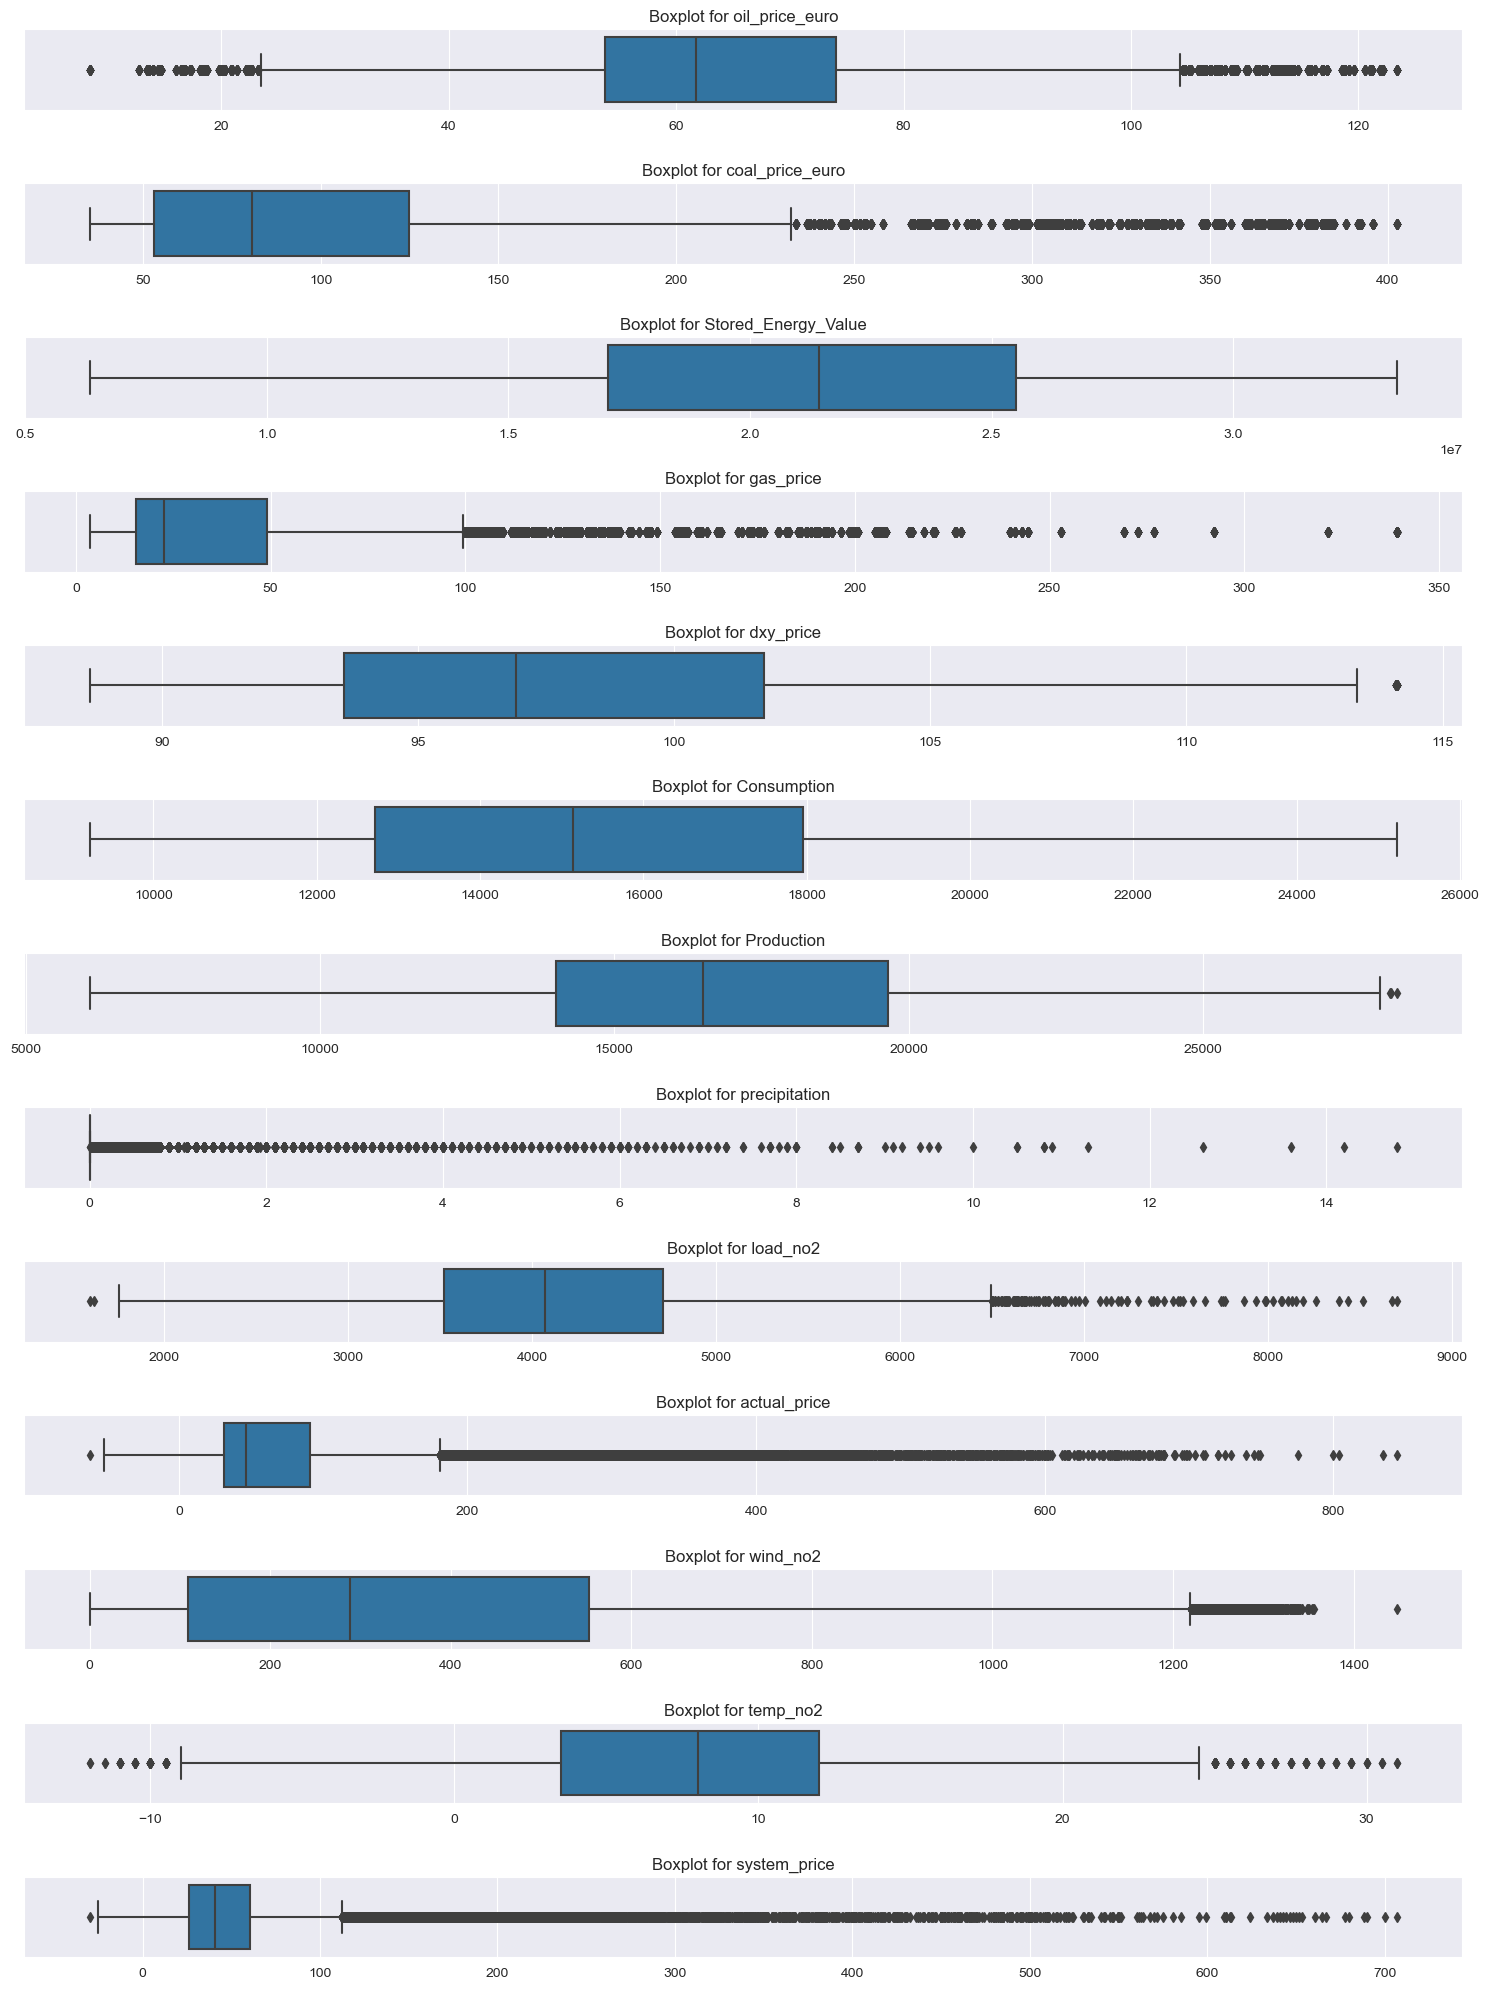

In [75]:
#Checking the outliers in the dataset
numerical_columns = merged_df.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(15, 20))  
for i, column in enumerate(numerical_columns):
    plt.subplot(len(numerical_columns), 1, i + 1)
    sns.boxplot(x=merged_df[column])
    plt.title(f'Boxplot for {column}')
    plt.xlabel('')  

plt.tight_layout() 
plt.show()


In [76]:
merged_df_2017 = merged_df[merged_df['year'] == 2017]
merged_df_2018 = merged_df[merged_df['year'] == 2018]
merged_df_2019 = merged_df[merged_df['year'] == 2019]
merged_df_2020 = merged_df[merged_df['year'] == 2020]
merged_df_2021 = merged_df[merged_df['year'] == 2021]
merged_df_2022 = merged_df[merged_df['year'] == 2022]
merged_df_2023 = merged_df[merged_df['year'] == 2023]

#### Plotting the price over time

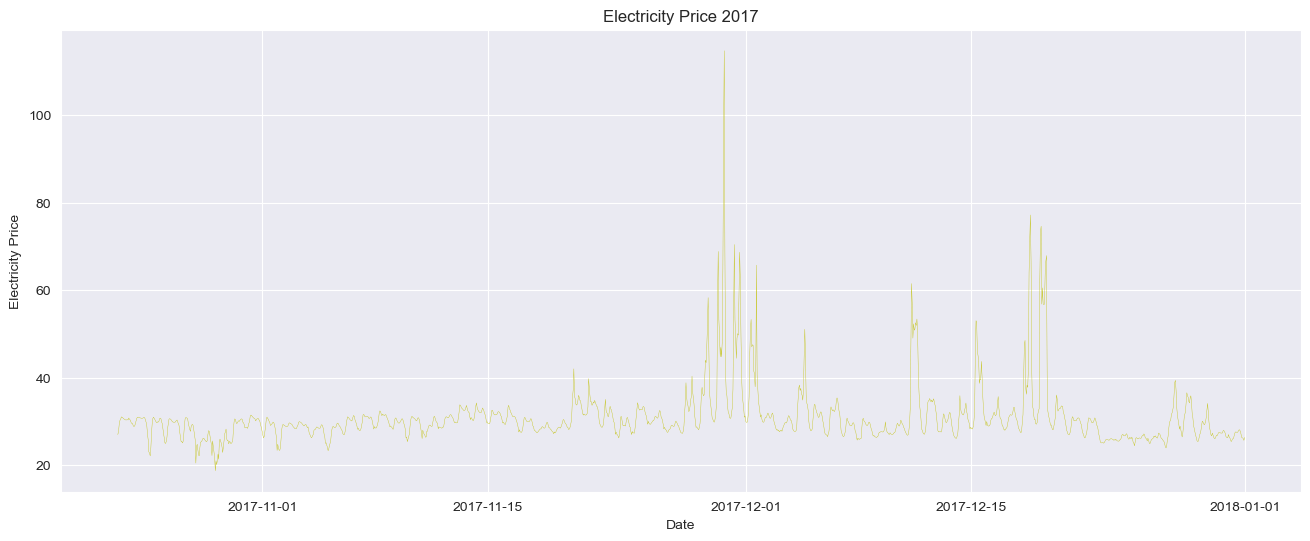

In [77]:
# Plot actual_price for 2017
plt.figure(figsize=(16, 6))
plt.plot(merged_df_2017['time'], merged_df_2017['actual_price'], color='y', linewidth=0.25)
plt.title('Electricity Price 2017')
plt.xlabel('Date')
plt.ylabel('Electricity Price')
plt.grid(True)
plt.show()


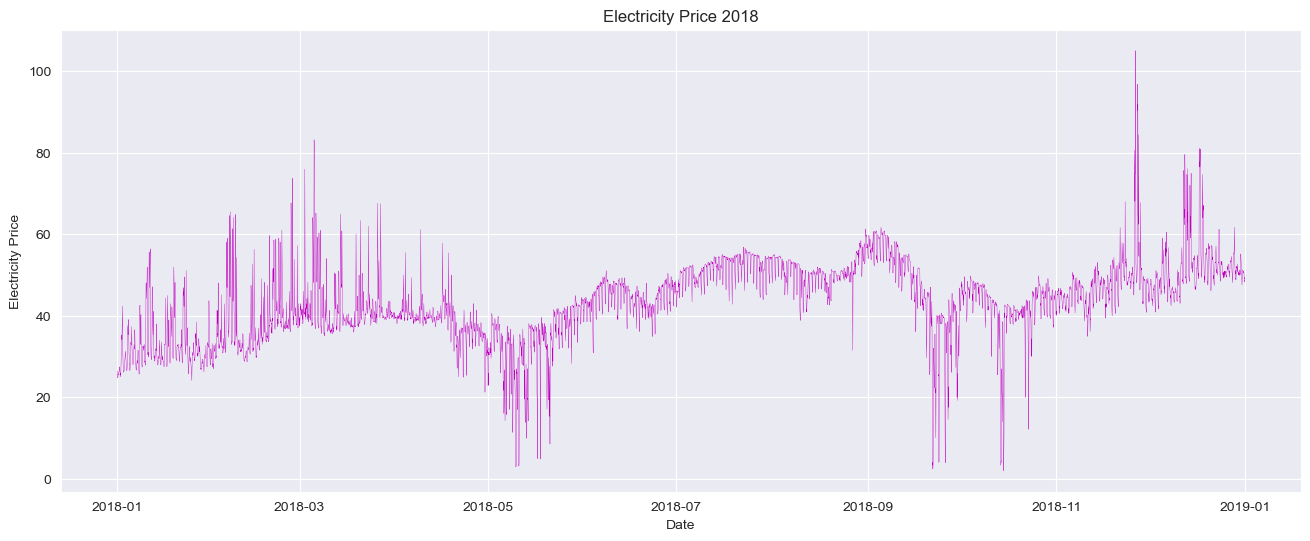

In [78]:
# Plot actual_price for 2018
plt.figure(figsize=(16, 6))
plt.plot(merged_df_2018['time'], merged_df_2018['actual_price'], color='m', linewidth=0.25)
plt.title('Electricity Price 2018')
plt.xlabel('Date')
plt.ylabel('Electricity Price')
plt.grid(True)
plt.show()


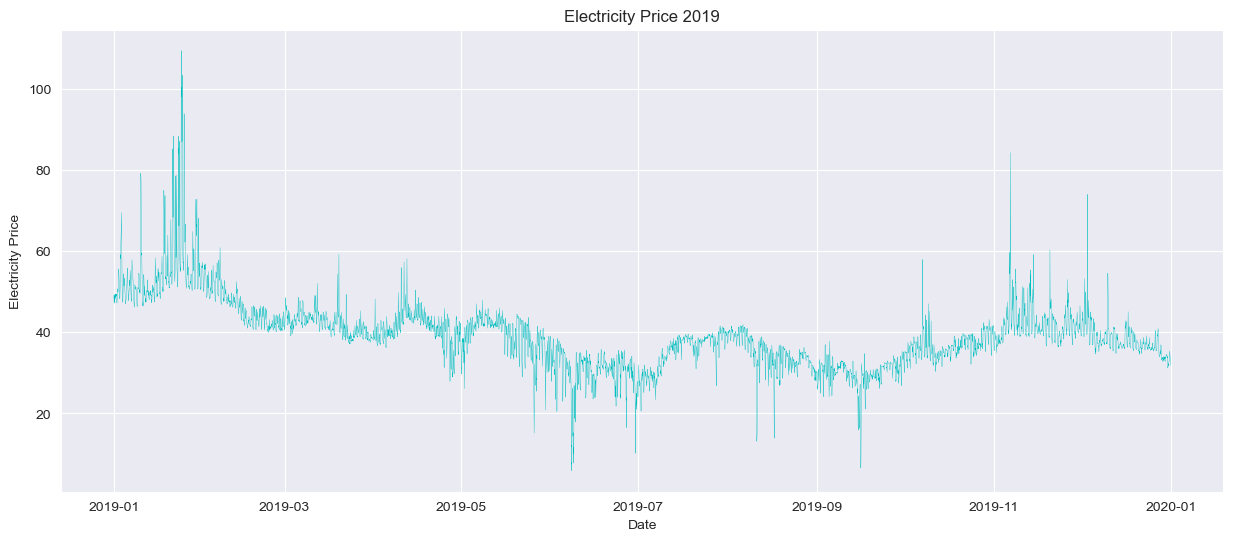

In [79]:
# Plot actual_price for 2019
plt.figure(figsize=(15, 6))
plt.plot(merged_df_2019['time'], merged_df_2019['actual_price'], color='c', linewidth=0.25)
plt.title('Electricity Price 2019')
plt.xlabel('Date')
plt.ylabel('Electricity Price')
plt.grid(True)
plt.show()

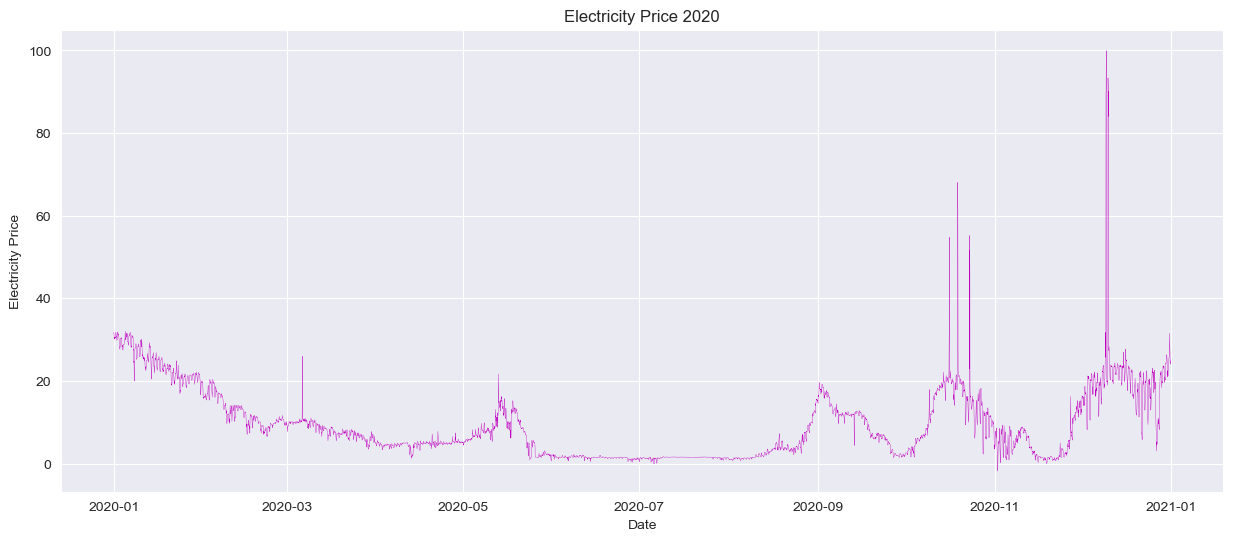

In [80]:
# Plot actual_price for 2020
plt.figure(figsize=(15, 6))
plt.plot(merged_df_2020['time'], merged_df_2020['actual_price'], color='m', linewidth=0.25)
plt.title('Electricity Price 2020')
plt.xlabel('Date')
plt.ylabel('Electricity Price')
plt.grid(True)
plt.show()

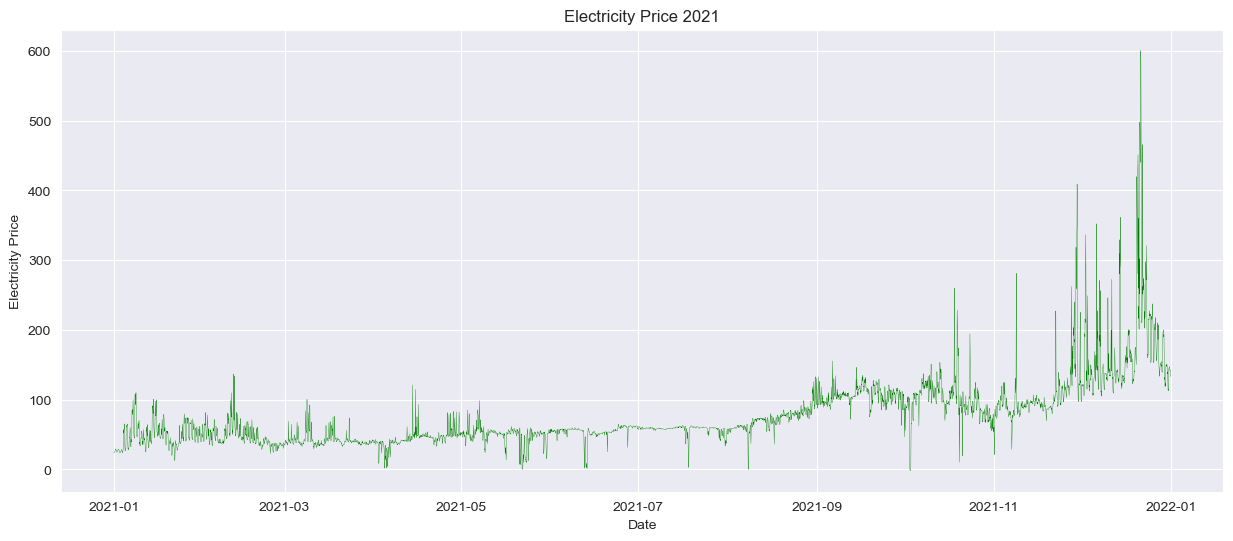

In [81]:
# Plot actual_price for 2021
plt.figure(figsize=(15, 6))
plt.plot(merged_df_2021['time'], merged_df_2021['actual_price'], color='g', linewidth=0.25)
plt.title('Electricity Price 2021')
plt.xlabel('Date')
plt.ylabel('Electricity Price')
plt.grid(True)
plt.show()

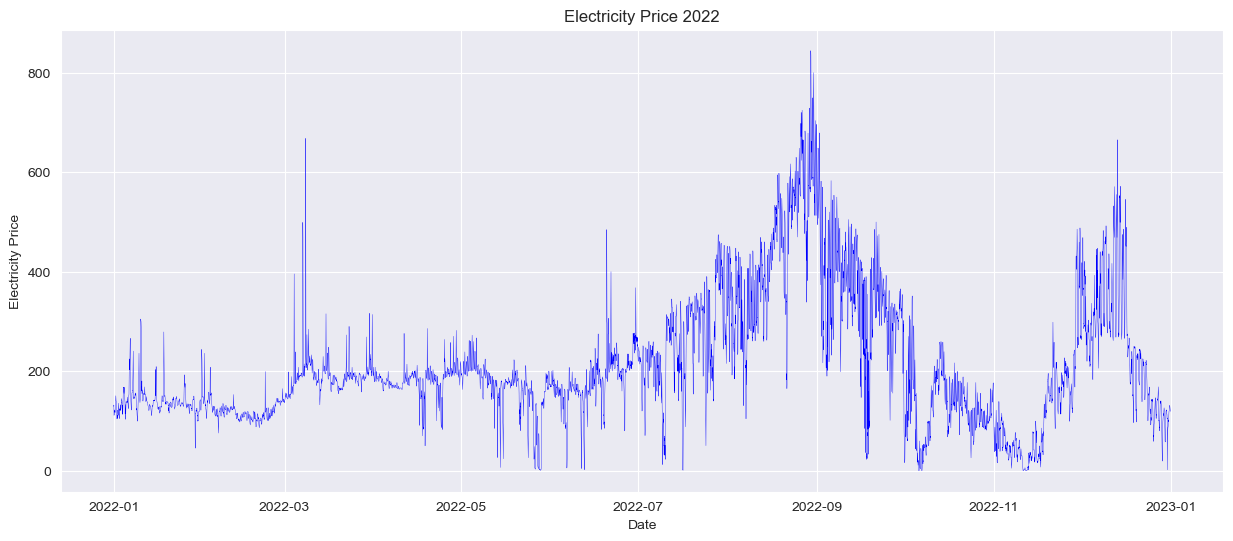

In [82]:
# Plot actual_price for 2022
plt.figure(figsize=(15, 6))
plt.plot(merged_df_2022['time'], merged_df_2022['actual_price'], color='b', linewidth=0.25)
plt.title('Electricity Price 2022')
plt.xlabel('Date')
plt.ylabel('Electricity Price')
plt.grid(True)
plt.show()

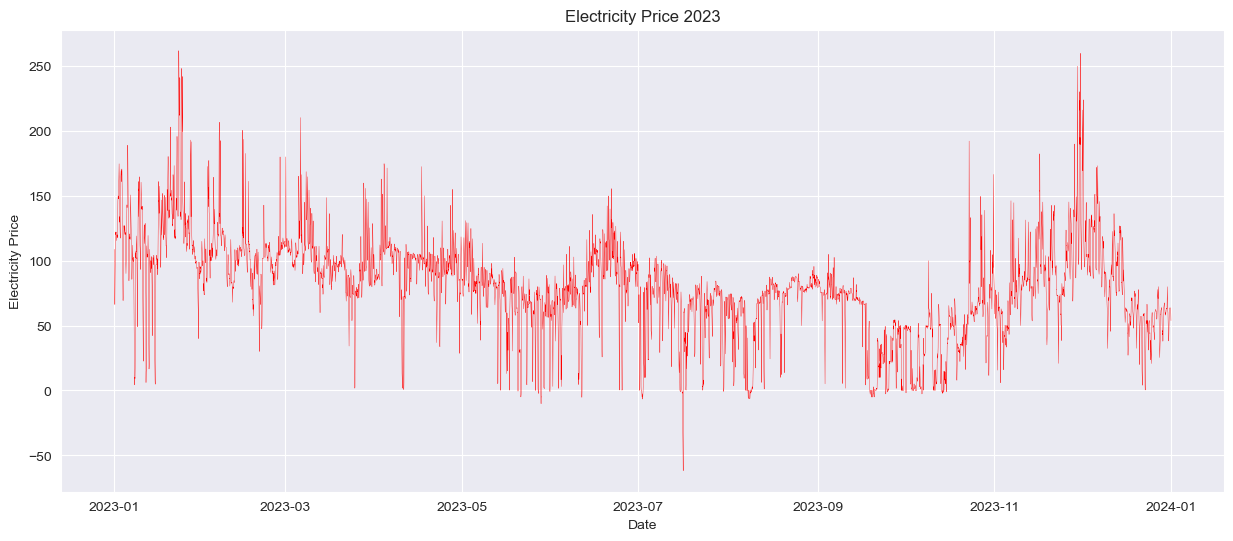

In [83]:
# Plot actual_price for 2023
plt.figure(figsize=(15, 6))
plt.plot(merged_df_2023['time'], merged_df_2023['actual_price'], color='r', linewidth=0.25)
plt.title('Electricity Price 2023')
plt.xlabel('Date')
plt.ylabel('Electricity Price')
plt.grid(True)
plt.show()

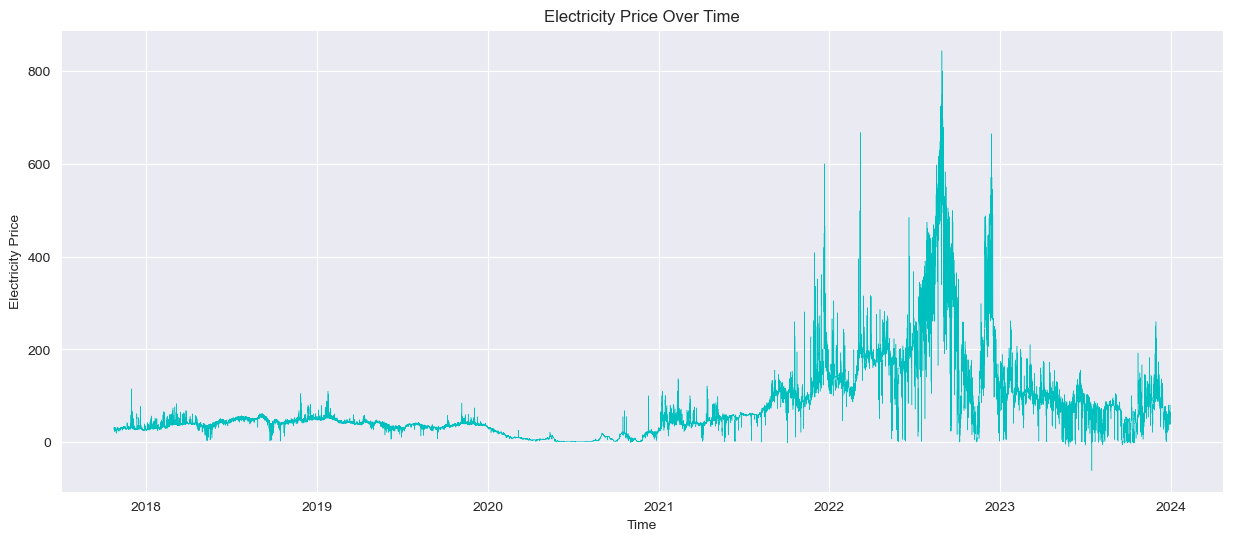

In [84]:
# plot the price for the entire dataset 
plt.figure(figsize=(15, 6))
plt.plot(merged_df['time'], merged_df['actual_price'], color='c', linewidth=0.35)
plt.title('Electricity Price Over Time')
plt.xlabel('Time')
plt.ylabel('Electricity Price')
plt.grid(True)
plt.show()


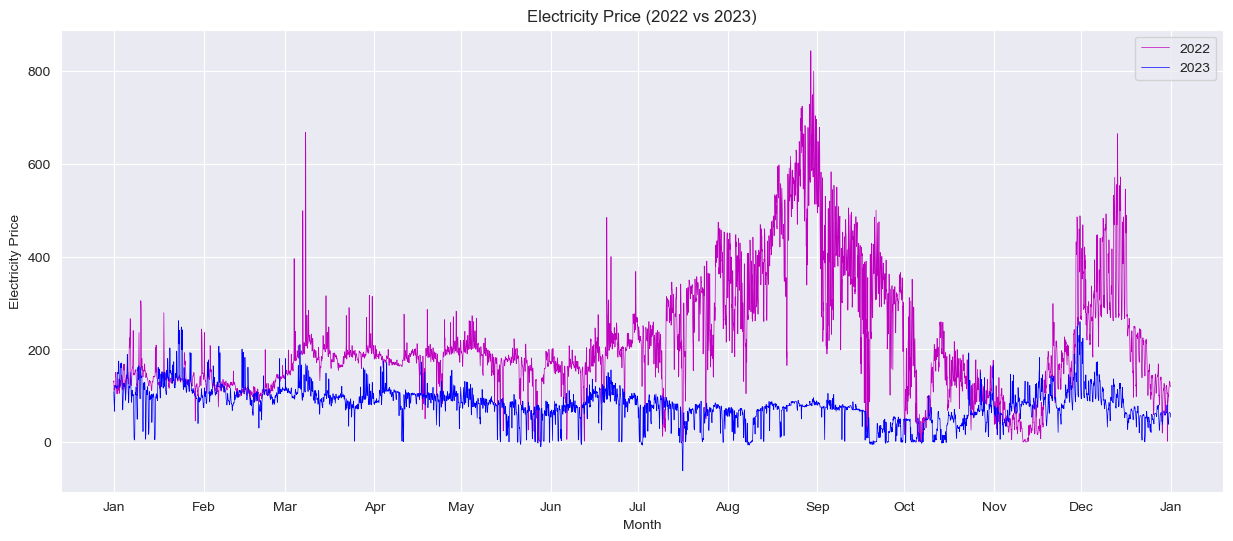

In [85]:
merged_df_2022_plot = merged_df_2022.copy()
merged_df_2023_plot = merged_df_2023.copy()

merged_df_2022_plot['plot_time'] = merged_df_2022_plot['time'].apply(lambda x: x.replace(year=2023))
merged_df_2023_plot['plot_time'] = merged_df_2023_plot['time'].apply(lambda x: x.replace(year=2023))

plt.figure(figsize=(15, 6))
plt.plot(merged_df_2022_plot['plot_time'], merged_df_2022_plot['actual_price'], color='m', linewidth=0.5, label='2022')
plt.plot(merged_df_2023_plot['plot_time'], merged_df_2023_plot['actual_price'], color='b', linewidth=0.5, label='2023')
plt.title('Electricity Price (2022 vs 2023)')
plt.xlabel('Month')
plt.ylabel('Electricity Price')
plt.legend()
plt.grid(True)


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.show()



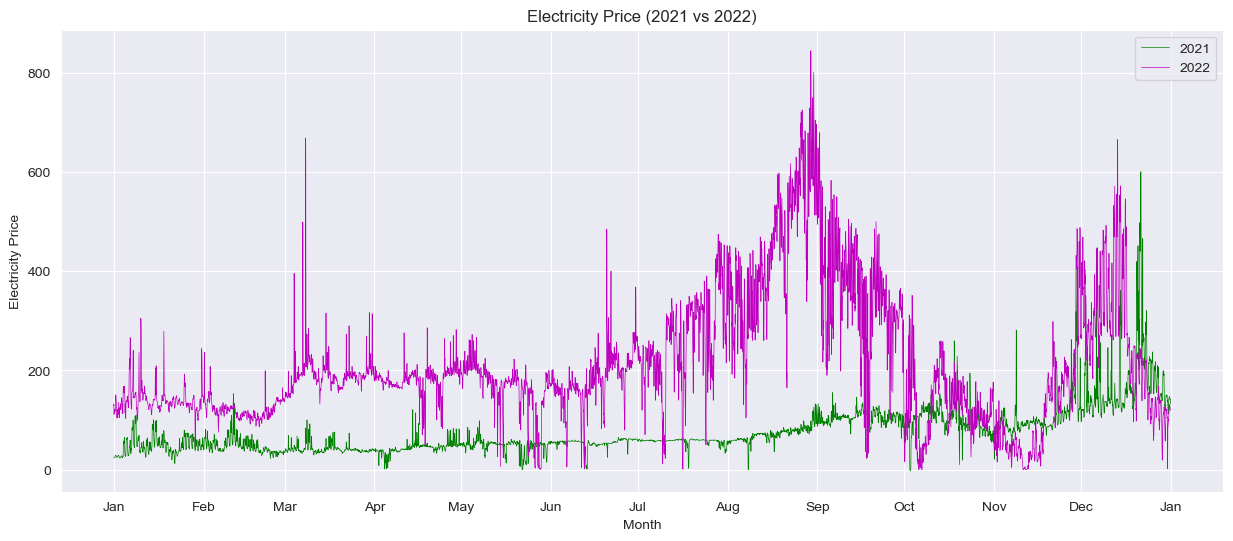

In [86]:
merged_df_2021_plot = merged_df_2021.copy()
merged_df_2022_plot = merged_df_2022.copy()

merged_df_2021_plot['plot_time'] = merged_df_2021_plot['time'].apply(lambda x: x.replace(year=2023))
merged_df_2022_plot['plot_time'] = merged_df_2022_plot['time'].apply(lambda x: x.replace(year=2023))

plt.figure(figsize=(15, 6))
plt.plot(merged_df_2021_plot['plot_time'], merged_df_2021_plot['actual_price'], color='g', linewidth=0.5, label='2021')
plt.plot(merged_df_2022_plot['plot_time'], merged_df_2022_plot['actual_price'], color='m', linewidth=0.5, label='2022')
plt.title('Electricity Price (2021 vs 2022)')
plt.xlabel('Month')
plt.ylabel('Electricity Price')
plt.legend()
plt.grid(True)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))  
plt.gca().xaxis.set_major_locator(mdates.MonthLocator()) 
plt.show()




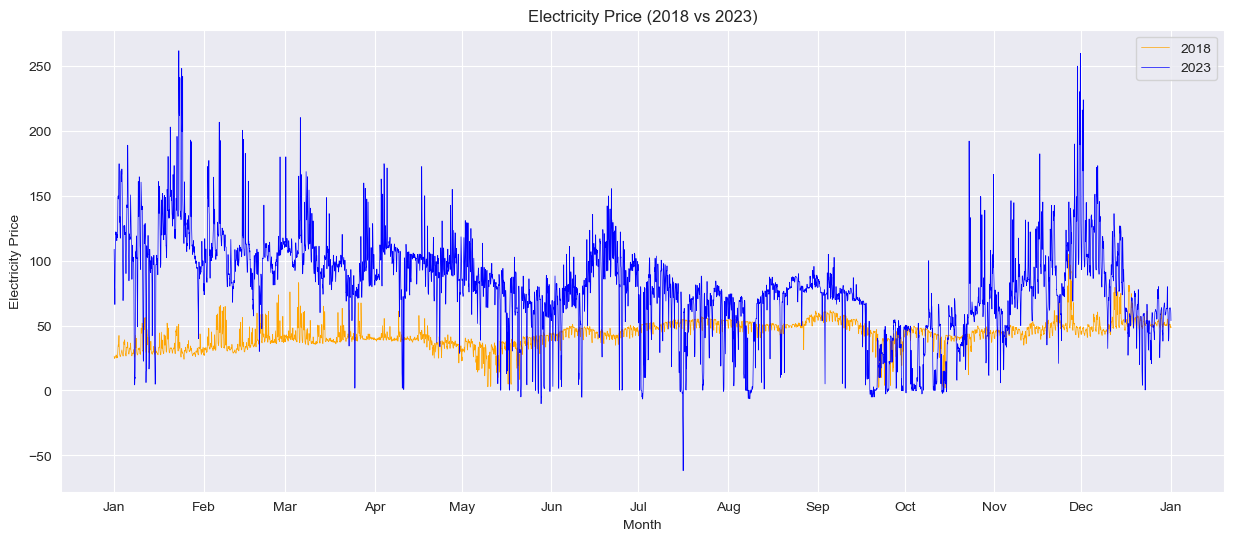

In [87]:
merged_df_2018_plot = merged_df_2018.copy()
merged_df_2023_plot = merged_df_2023.copy()

merged_df_2018_plot['plot_time'] = merged_df_2018_plot['time'].apply(lambda x: x.replace(year=2023))
merged_df_2023_plot['plot_time'] = merged_df_2023_plot['time']

plt.figure(figsize=(15, 6))
plt.plot(merged_df_2018_plot['plot_time'], merged_df_2018_plot['actual_price'], color='orange', linewidth=0.5, label='2018')
plt.plot(merged_df_2023_plot['plot_time'], merged_df_2023_plot['actual_price'], color='blue', linewidth=0.5, label='2023')
plt.title('Electricity Price (2018 vs 2023)')
plt.xlabel('Month')
plt.ylabel('Electricity Price')
plt.legend()
plt.grid(True)


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b')) 
plt.gca().xaxis.set_major_locator(mdates.MonthLocator()) 
plt.show()


### Destribution of Electricity price

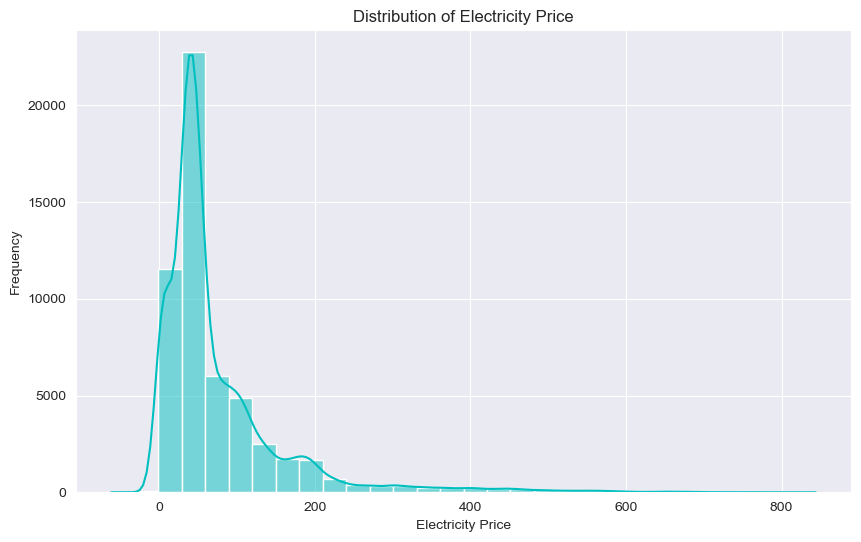

In [88]:
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['actual_price'], bins=30, kde=True, color='c')
plt.title('Distribution of Electricity Price')
plt.xlabel('Electricity Price')
plt.ylabel('Frequency')
plt.show()

In [89]:
# Descriptive statistics of the price_no2 column based on the year
merged_df.groupby('year')['actual_price'].describe()


count        mean         std    min       25%      50%       75%  \
year                                                                       
2017  1680.0   30.780473    6.641674  18.71   27.7725   29.680   31.3625   
2018  8760.0   43.252471    9.376723   1.92   37.9300   43.630   49.7700   
2019  8760.0   39.264215    8.231145   5.86   34.1775   38.810   42.8800   
2020  8784.0    9.290337    8.259988  -1.73    2.1300    6.950   13.5525   
2021  8760.0   75.107840   47.215331  -1.97   46.5750   59.340   94.9325   
2022  8760.0  211.275744  125.850824   0.04  132.6350  181.130  253.9175   
2023  8760.0   79.438957   36.284407 -61.84   61.4050   80.455  100.8200   

         max  
year          
2017  114.70  
2018  105.02  
2019  109.45  
2020   99.92  
2021  600.16  
2022  844.00  
2023  261.85

### Seasonal Decomposition  

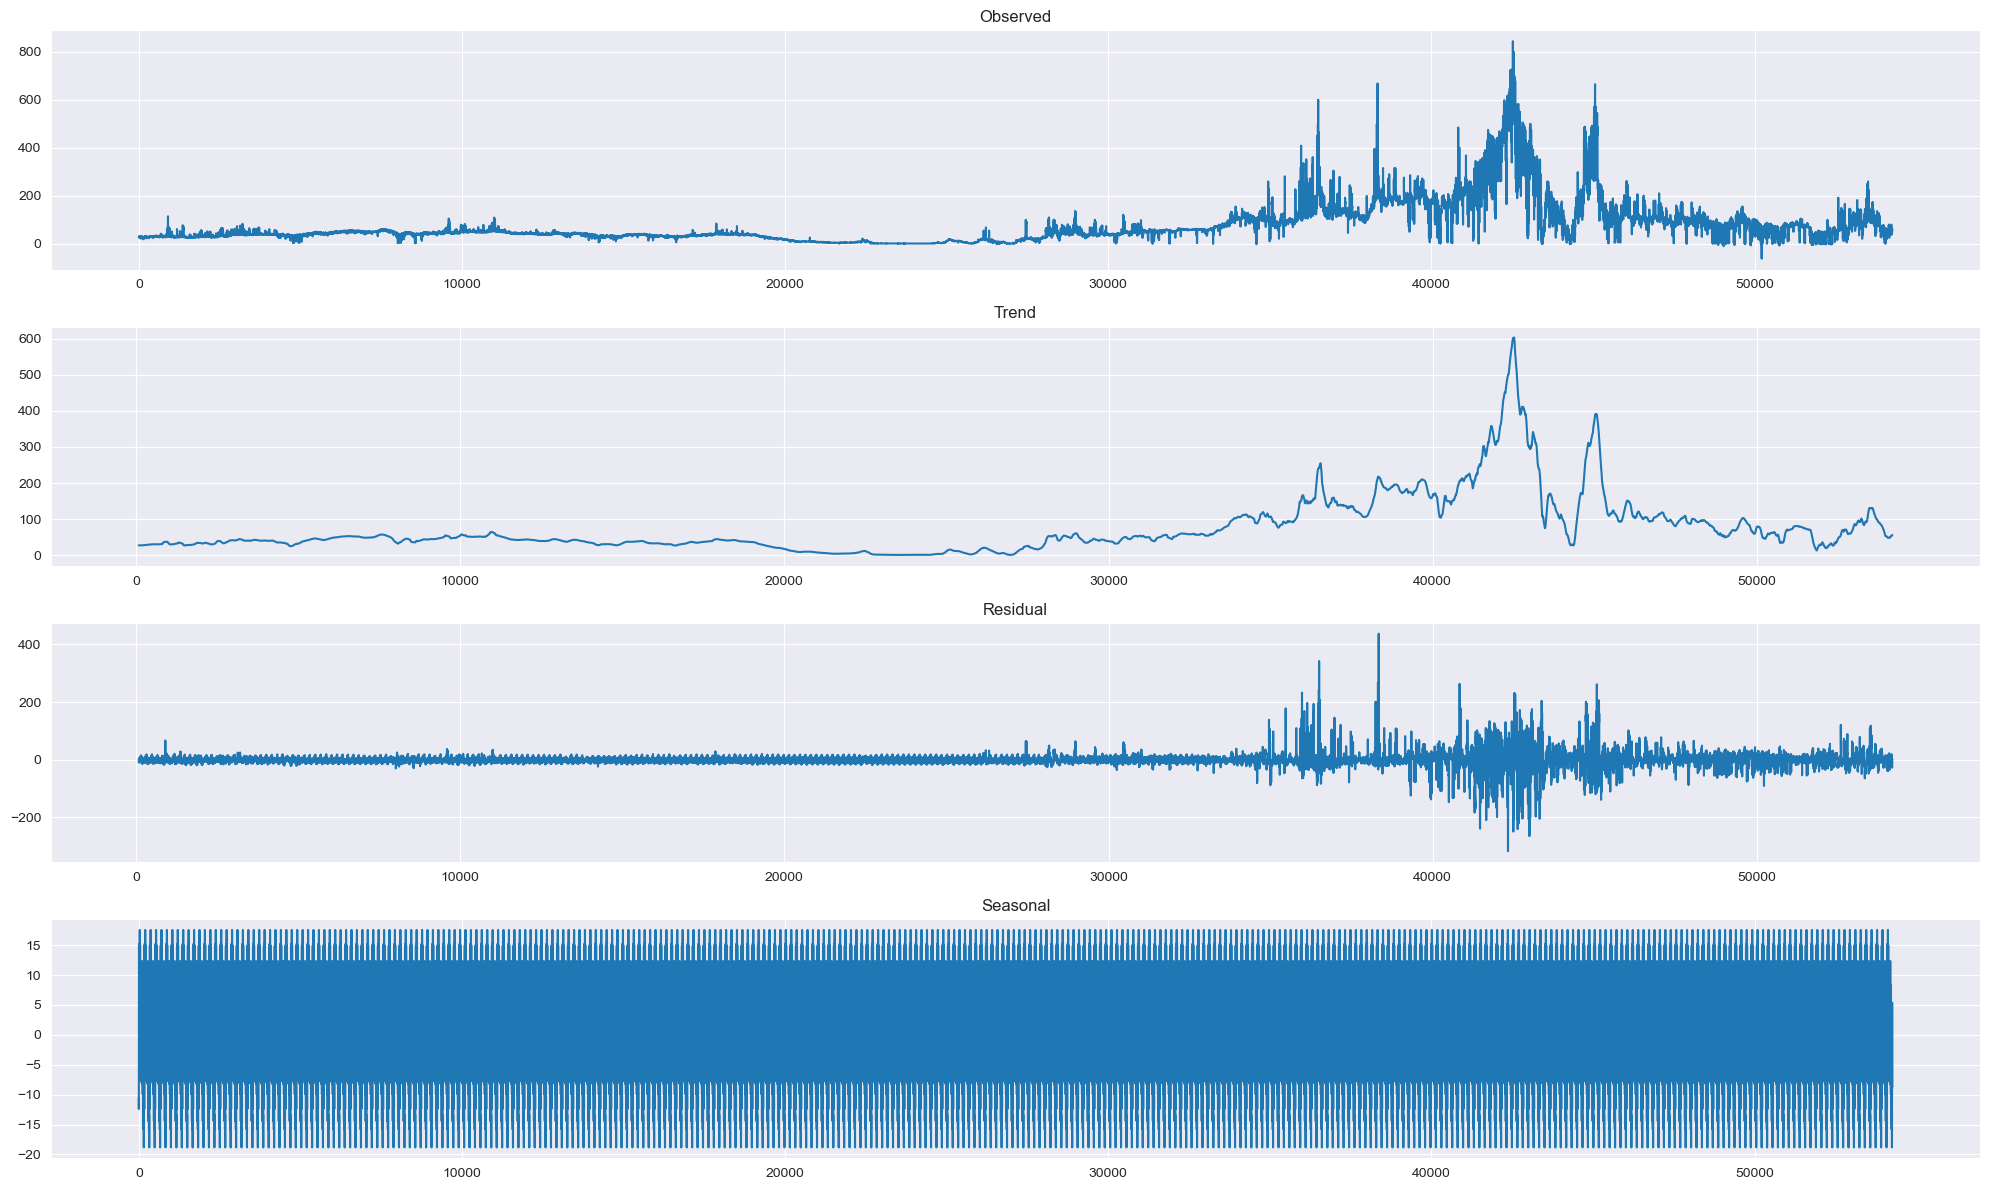

In [90]:
res = sm.tsa.seasonal_decompose(merged_df['actual_price'], model='additive', period=24*7)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()

### ACF and PACF plots

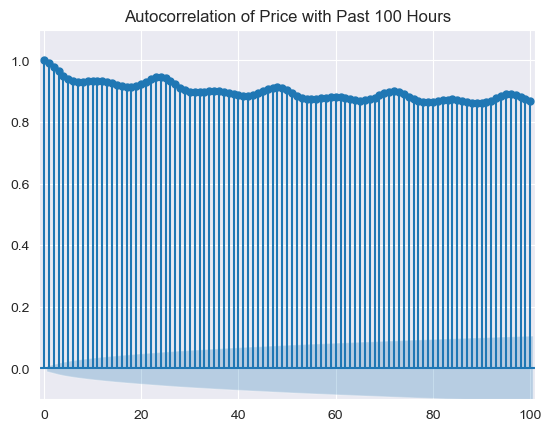

In [91]:
fig, ax = plt.subplots()
plot_acf(merged_df['actual_price'], lags=100, ax=ax, title='Autocorrelation of Price with Past 100 Hours')
ax.set_xlim(-1, 101)
ax.set_ylim(-0.1, 1.1)
plt.show()

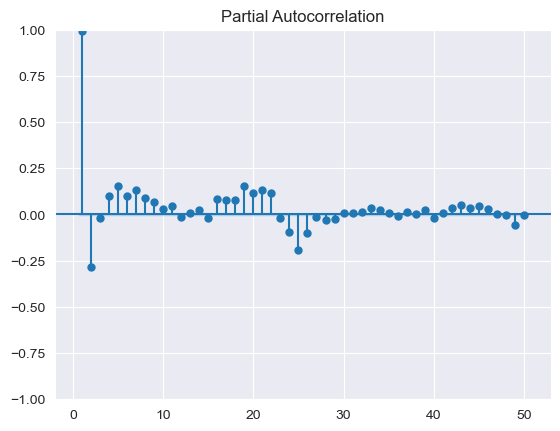

In [92]:
plot_pacf(merged_df['actual_price'], lags=50, zero=False)
plt.show()

In [93]:
result = adfuller(merged_df['actual_price'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.277828753967025
p-value: 6.085400632952149e-06
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


### Rolling Mean

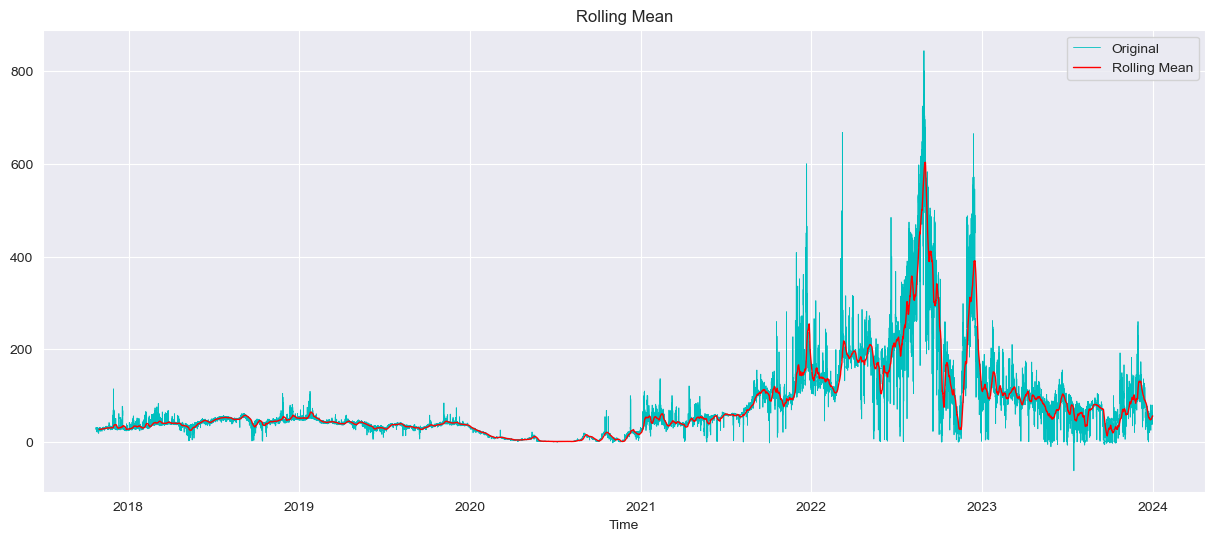

In [94]:
plt.figure(figsize=(15, 6))
rolling_mean= merged_df['actual_price'].rolling(window=24*7).mean()
plt.plot(merged_df['time'], merged_df['actual_price'], color='c', linewidth=0.6, label='Original')
plt.plot(merged_df['time'], rolling_mean, color='r', linewidth=1, label='Rolling Mean')
plt.legend()
plt.title('Rolling Mean')
plt.xlabel('Time')
plt.show()

### Visualizing electricity price by hour of the day

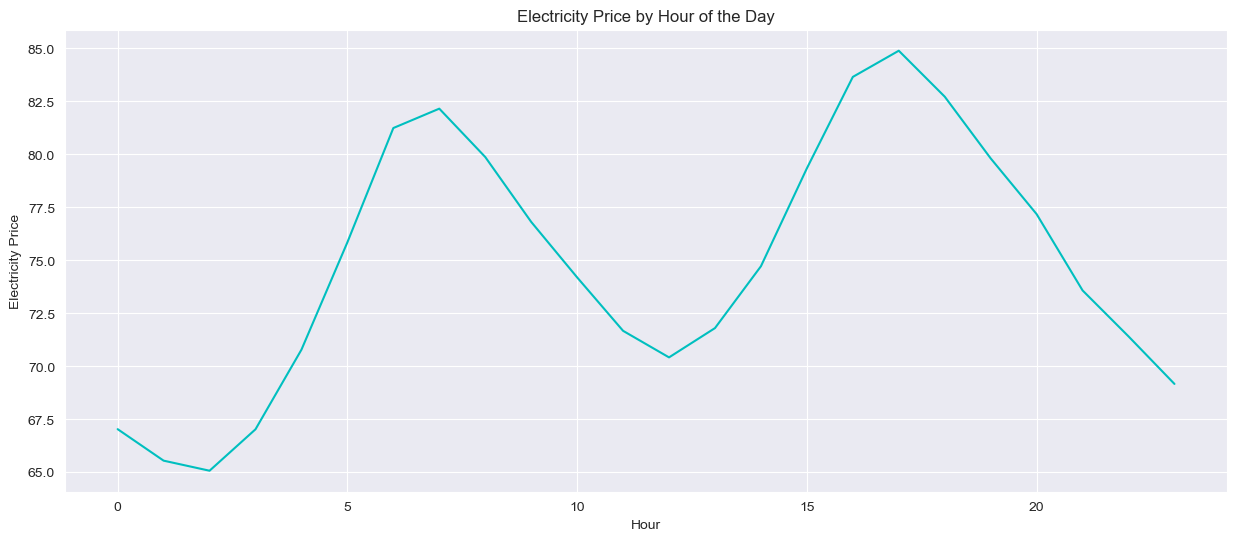

In [95]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=merged_df, x='hour', y='actual_price',errorbar=None, color='c')
plt.title('Electricity Price by Hour of the Day')
plt.xlabel('Hour')
plt.ylabel('Electricity Price')
plt.grid(True)
plt.show()


### Visualizing electricity price by month


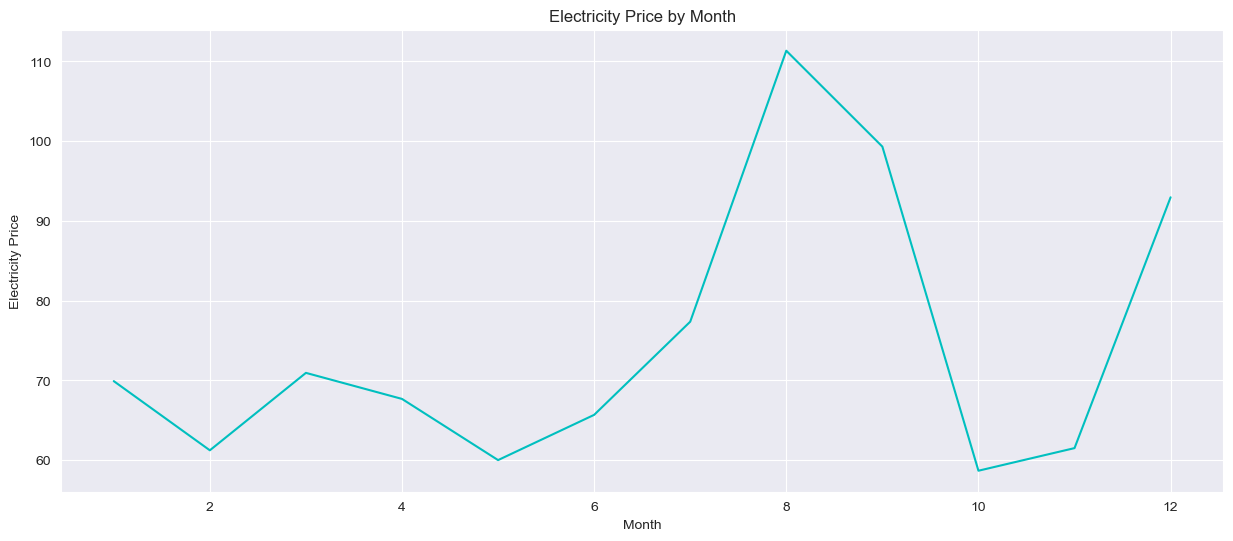

In [96]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=merged_df, x='month', y='actual_price', errorbar=None, color='c')
plt.title('Electricity Price by Month')
plt.xlabel('Month')
plt.ylabel('Electricity Price')
plt.grid(True)
plt.show()

### Visualizing the price by month using a box plot

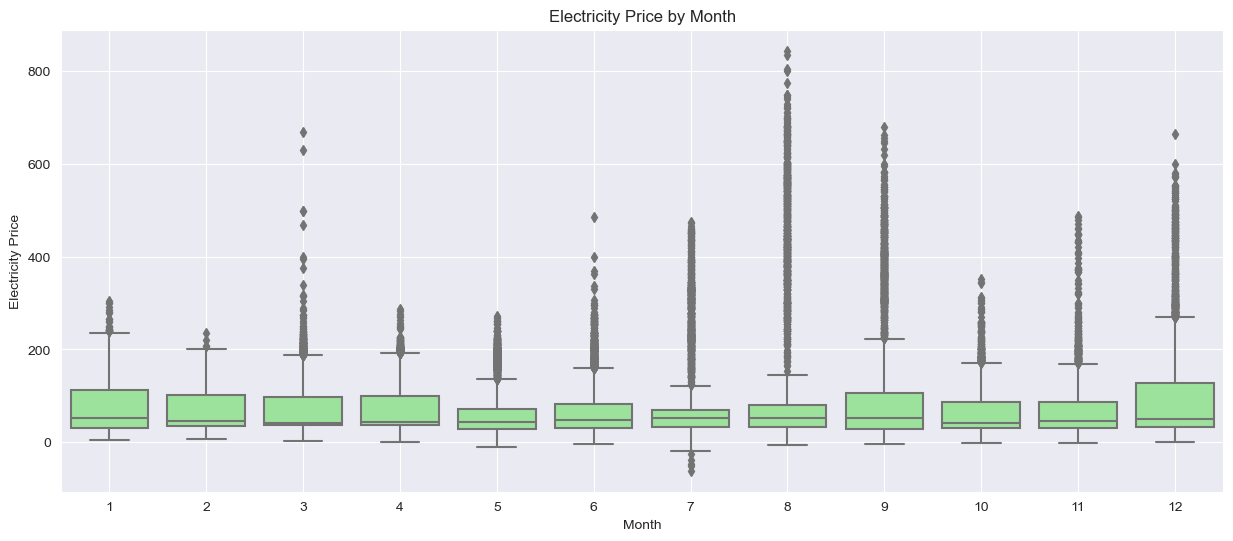

In [97]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=merged_df, x='month', y='actual_price', color='lightgreen')
plt.title('Electricity Price by Month')
plt.xlabel('Month')
plt.ylabel('Electricity Price')
plt.grid(True)

### Visualizing the price by week and day of the week using a bar plot

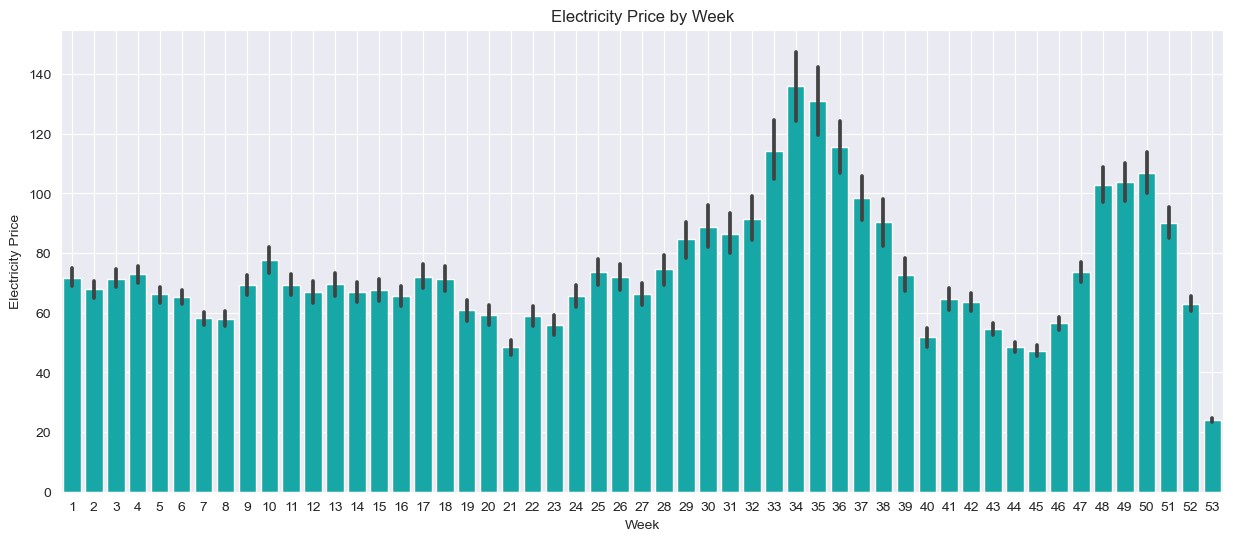

In [98]:
plt.figure(figsize=(15, 6))
sns.barplot(data=merged_df, x='week', y='actual_price', color='c')
plt.title('Electricity Price by Week')
plt.xlabel('Week')
plt.ylabel('Electricity Price')
plt.grid(True)
plt.show()

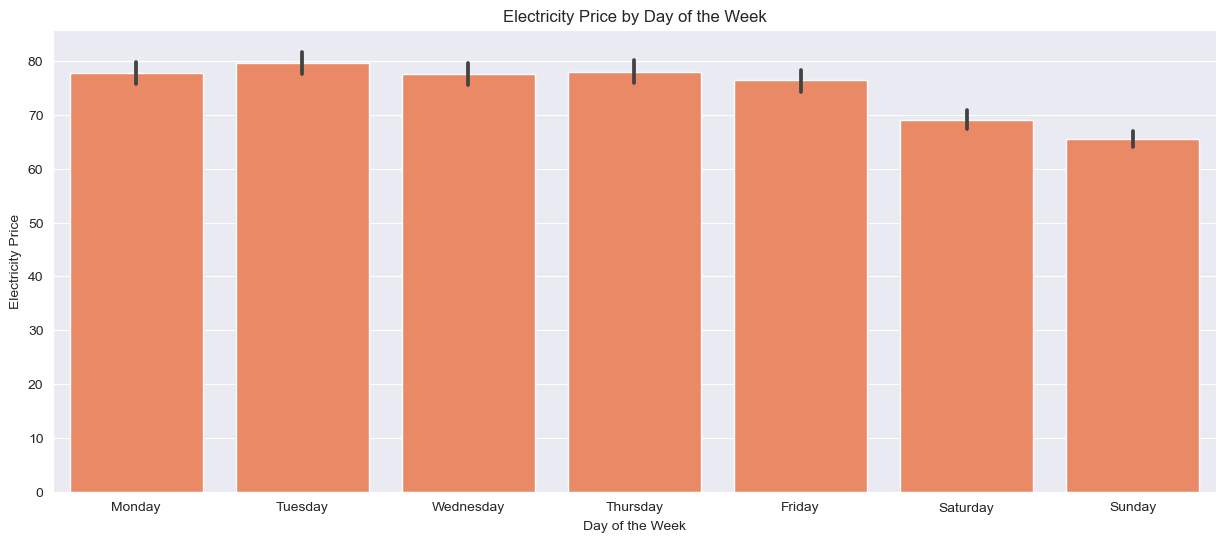

In [99]:
plt.figure(figsize=(15, 6))
sns.barplot(data=merged_df, x='day_of_week', y='actual_price', color='coral')
plt.title('Electricity Price by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Electricity Price')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

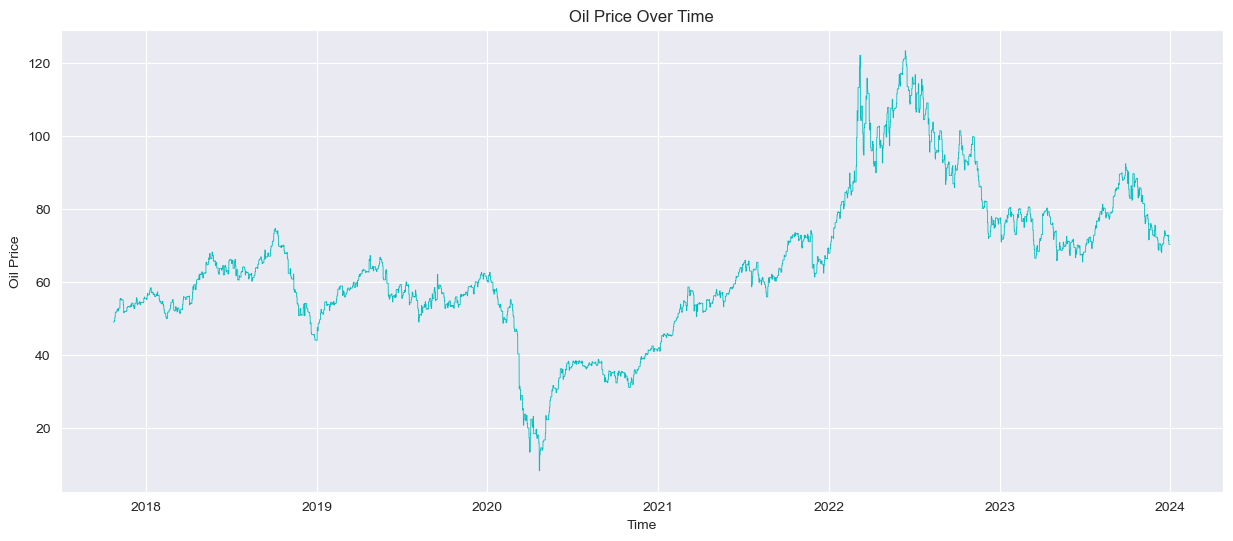

In [100]:
# Plot the oil price over time
plt.figure(figsize=(15, 6))
plt.plot(merged_df['time'], merged_df['oil_price_euro'], color='c', linewidth=0.6)
plt.title('Oil Price Over Time')
plt.xlabel('Time')
plt.ylabel('Oil Price')
plt.grid(True)
plt.show()

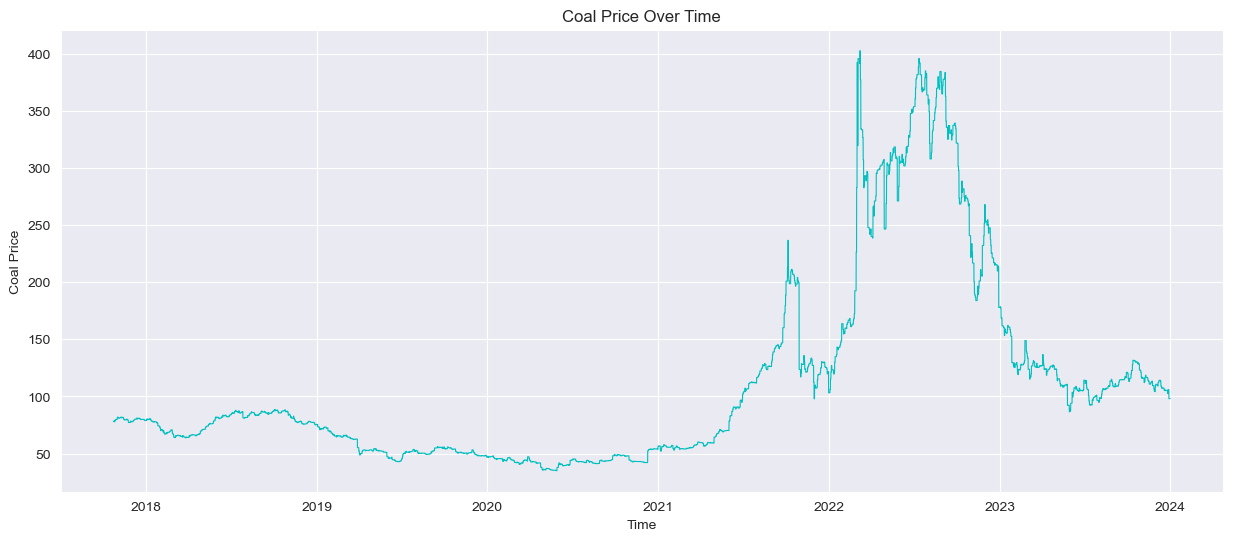

In [101]:
# plot the coal price over time
plt.figure(figsize=(15, 6))
plt.plot(merged_df['time'], merged_df['coal_price_euro'], color='c', linewidth=0.8)
plt.title('Coal Price Over Time')
plt.xlabel('Time')
plt.ylabel('Coal Price')
plt.grid(True)
plt.show()

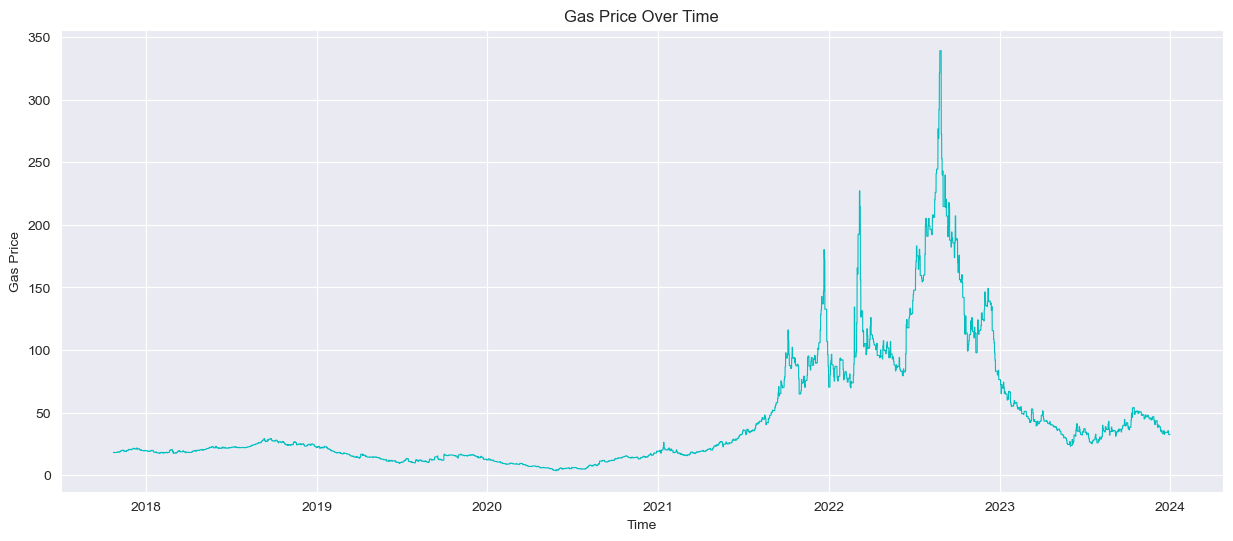

In [102]:
# plot the gas price over time
plt.figure(figsize=(15, 6))
plt.plot(merged_df['time'], merged_df['gas_price'], color='c', linewidth=0.8)
plt.title('Gas Price Over Time')
plt.xlabel('Time')
plt.ylabel('Gas Price')
plt.grid(True)
plt.show()

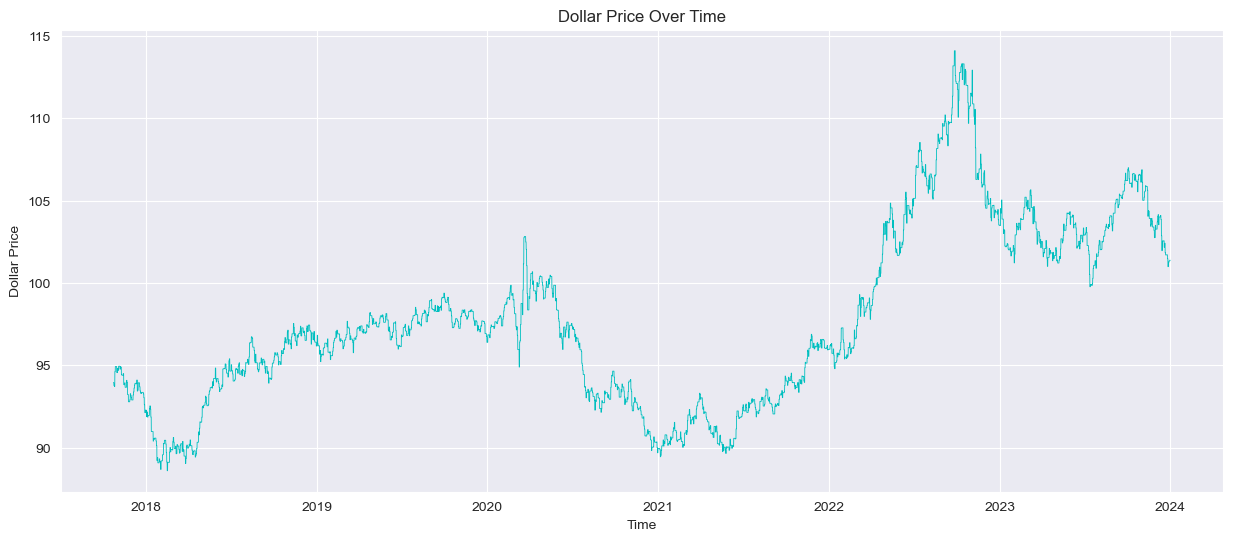

In [103]:
# plot the dollar price over time
plt.figure(figsize=(15, 6))
plt.plot(merged_df['time'], merged_df['dxy_price'], color='c', linewidth=0.6)
plt.title('Dollar Price Over Time')
plt.xlabel('Time')
plt.ylabel('Dollar Price')
plt.grid(True)
plt.show()

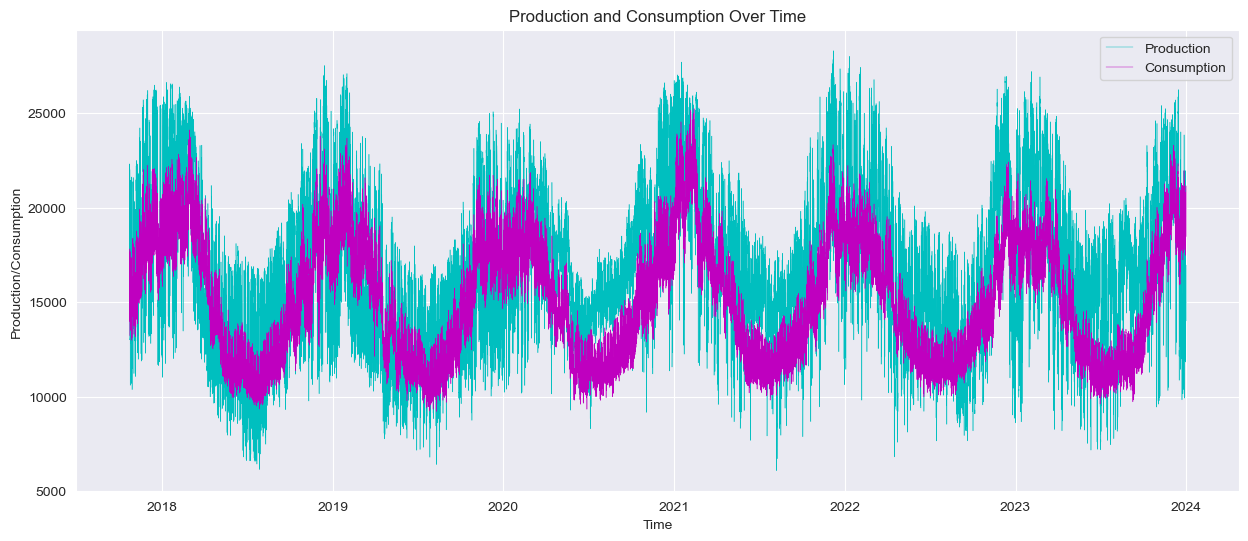

In [104]:
# plot the production and consumption over time
plt.figure(figsize=(15, 6))
plt.plot(merged_df['time'], merged_df['Production'], color='c', linewidth=0.35, label='Production')
plt.plot(merged_df['time'], merged_df['Consumption'], color='m', linewidth=0.35, label='Consumption')
plt.title('Production and Consumption Over Time')
plt.xlabel('Time')
plt.ylabel('Production/Consumption')
plt.legend()
plt.grid(True)
plt.show()

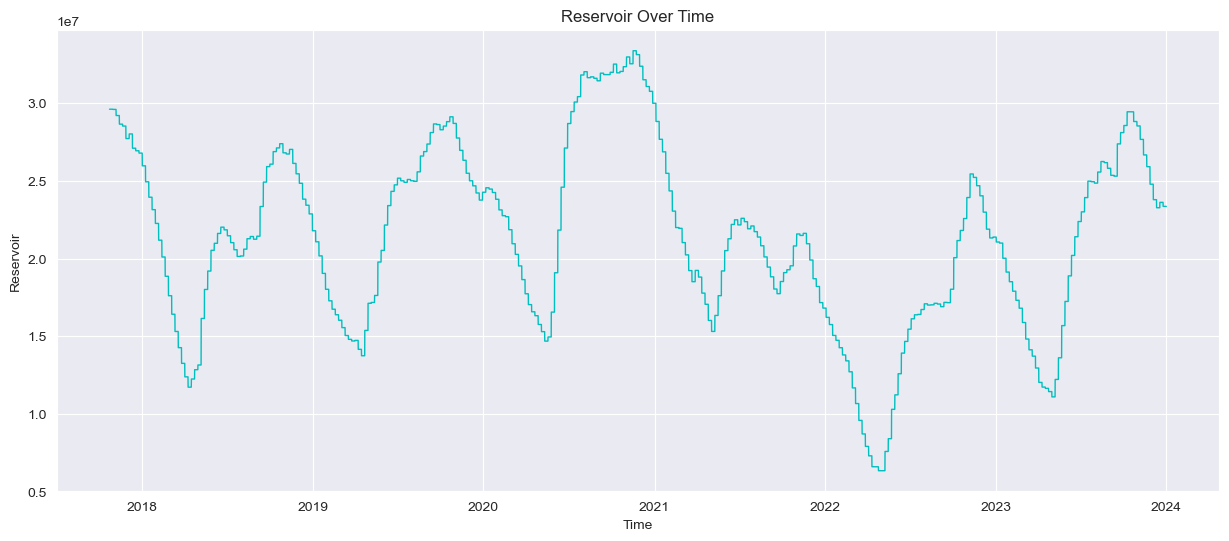

In [105]:
# plot the reservoir over time
plt.figure(figsize=(15, 6))
plt.plot(merged_df['time'], merged_df['Stored_Energy_Value'], color='c', linewidth=1)
plt.title('Reservoir Over Time')
plt.xlabel('Time')
plt.ylabel('Reservoir')
plt.grid(True)
plt.show()

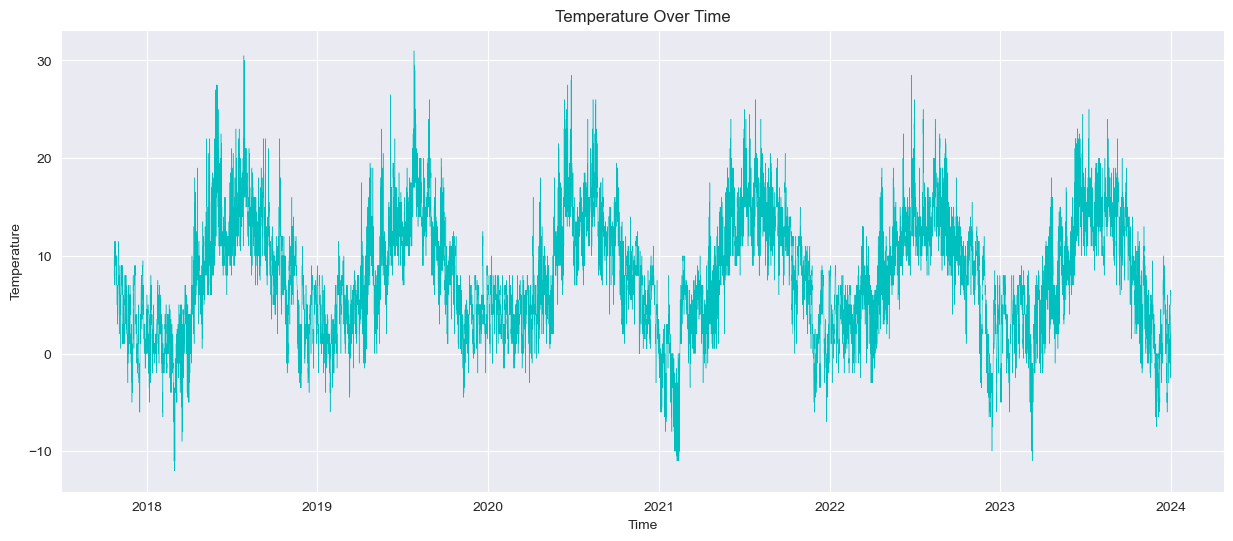

In [106]:
# plot the temperature over time
plt.figure(figsize=(15, 6))
plt.plot(merged_df['time'], merged_df['temp_no2'], color='c', linewidth=0.35)
plt.title('Temperature Over Time')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.grid(True)
plt.show()

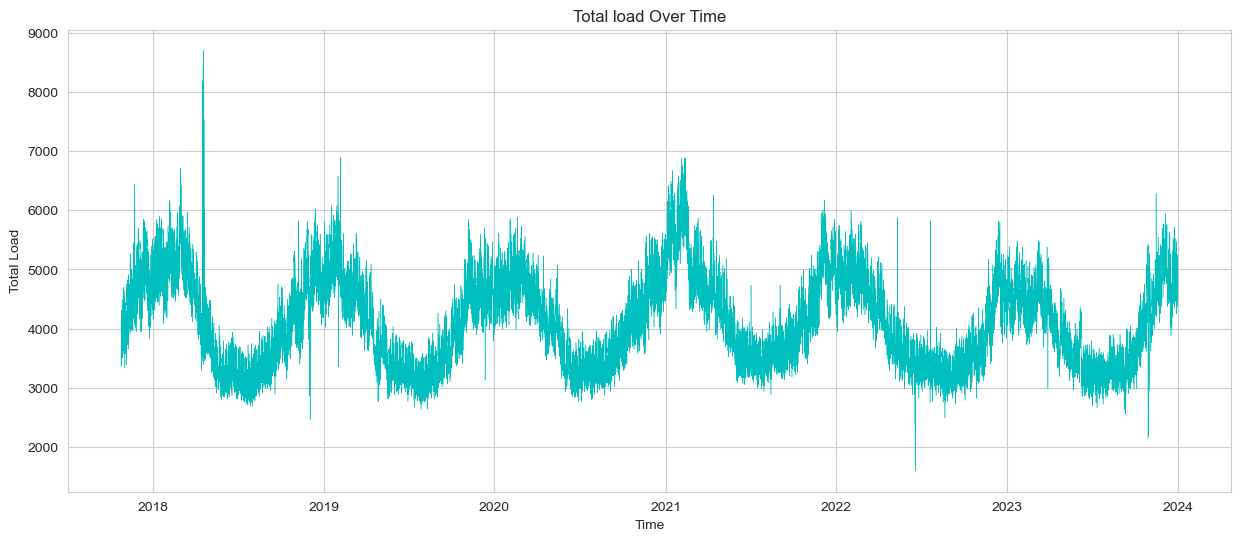

In [144]:
# plot the temperature over time
plt.figure(figsize=(15, 6))
plt.plot(merged_df['time'], merged_df['load_no2'], color='c', linewidth=0.35)
plt.title('Total load Over Time')
plt.xlabel('Time')
plt.ylabel('Total Load')
plt.grid(True)
plt.show()

### Visualizating relationship between the features and the target variable

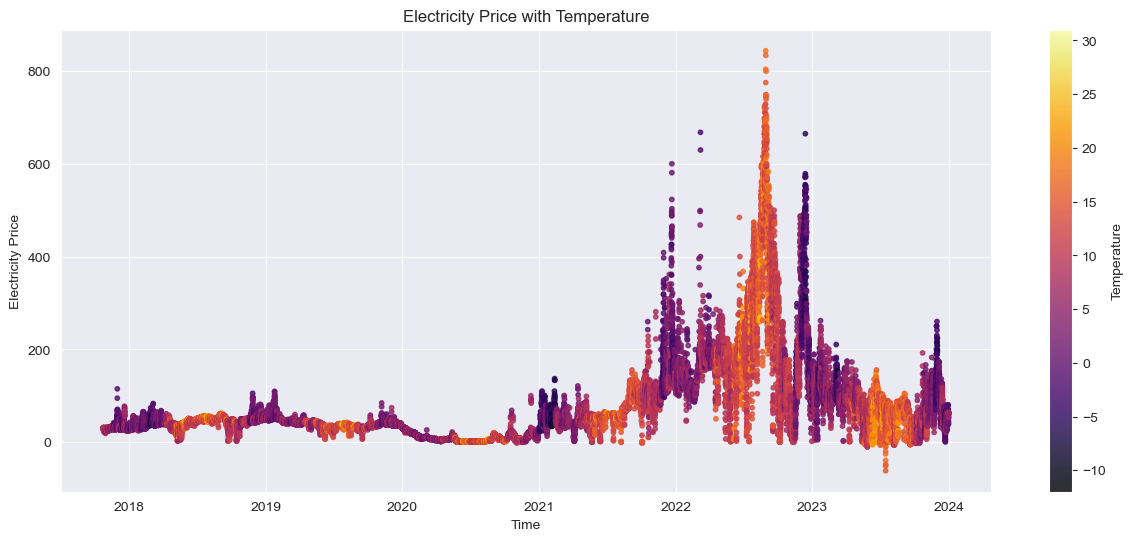

In [107]:
plt.figure(figsize=(15, 6))
scatter = plt.scatter(
    merged_df['time'], 
    merged_df['actual_price'], 
    c=merged_df['temp_no2'],  
    cmap='inferno',          
    s=10,                     
    alpha=0.8                 
)

cbar = plt.colorbar(scatter)
cbar.set_label('Temperature')
plt.title('Electricity Price with Temperature')
plt.xlabel('Time')
plt.ylabel('Electricity Price')
plt.grid(True)
plt.show()


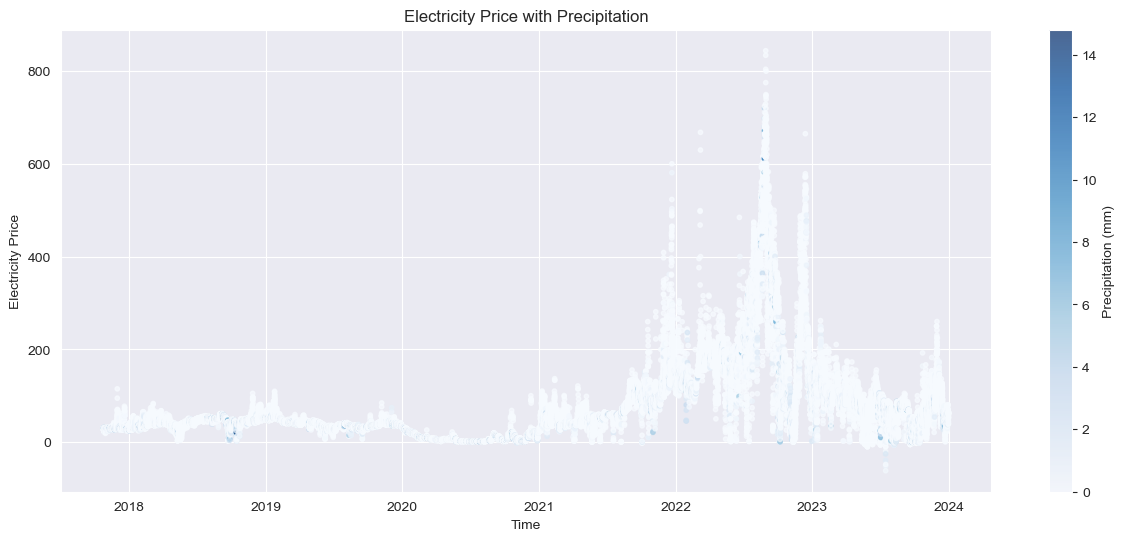

In [108]:
plt.figure(figsize=(15, 6))
scatter = plt.scatter(
    merged_df['time'], 
    merged_df['actual_price'], 
    c=merged_df['precipitation'], 
    cmap='Blues',                 
    s=10,                        
    alpha=0.7                     
)

cbar = plt.colorbar(scatter)
cbar.set_label('Precipitation (mm)')
plt.title('Electricity Price with Precipitation')
plt.xlabel('Time')
plt.ylabel('Electricity Price')
plt.grid(True)
plt.show()


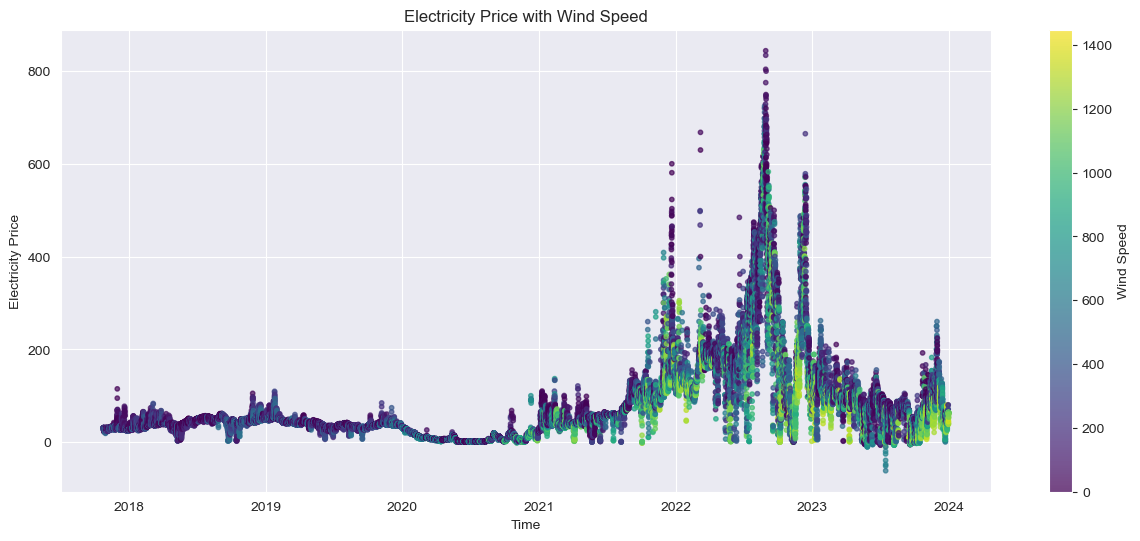

In [109]:

plt.figure(figsize=(15, 6))
scatter = plt.scatter(
    merged_df['time'], 
    merged_df['actual_price'], 
    c=merged_df['wind_no2'],  
    cmap='viridis',           
    s=10,                     
    alpha=0.7                 
)

cbar = plt.colorbar(scatter)
cbar.set_label('Wind Speed')
plt.title('Electricity Price with Wind Speed')
plt.xlabel('Time')
plt.ylabel('Electricity Price')
plt.grid(True)
plt.show()

    
    

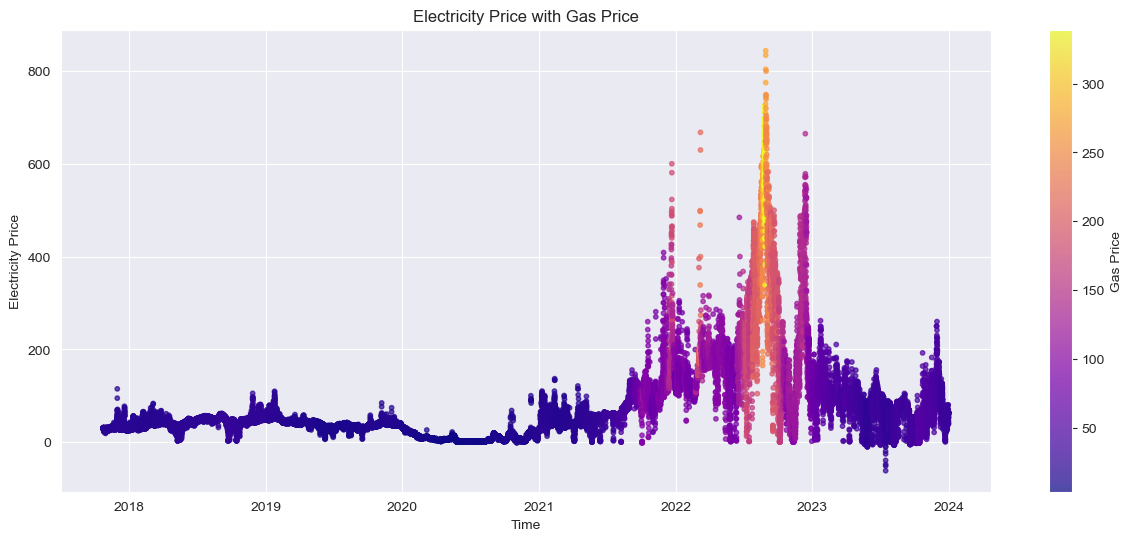

In [110]:
# Plotting the electricity price with the gas price
plt.figure(figsize=(15, 6))
scatter = plt.scatter(
    merged_df['time'], 
    merged_df['actual_price'], 
    c=merged_df['gas_price'],  
    cmap='plasma',             
    s=10,                      
    alpha=0.7                  
)

cbar = plt.colorbar(scatter)
cbar.set_label('Gas Price')
plt.title('Electricity Price with Gas Price')
plt.xlabel('Time')
plt.ylabel('Electricity Price')
plt.grid(True)
plt.show()


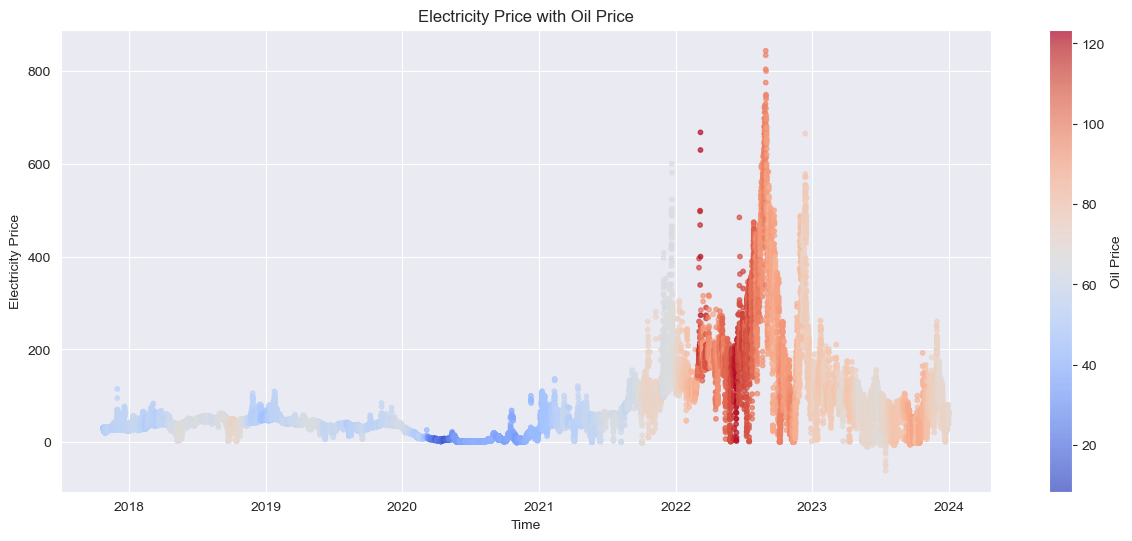

In [111]:
# Plotting the electricity price with the oil price
plt.figure(figsize=(15, 6))
scatter = plt.scatter(
    merged_df['time'], 
    merged_df['actual_price'], 
    c=merged_df['oil_price_euro'],  
    cmap='coolwarm',           
    s=10,                      
    alpha=0.7                  
)

cbar = plt.colorbar(scatter)
cbar.set_label('Oil Price')
plt.title('Electricity Price with Oil Price')
plt.xlabel('Time')
plt.ylabel('Electricity Price')
plt.grid(True)
plt.show()


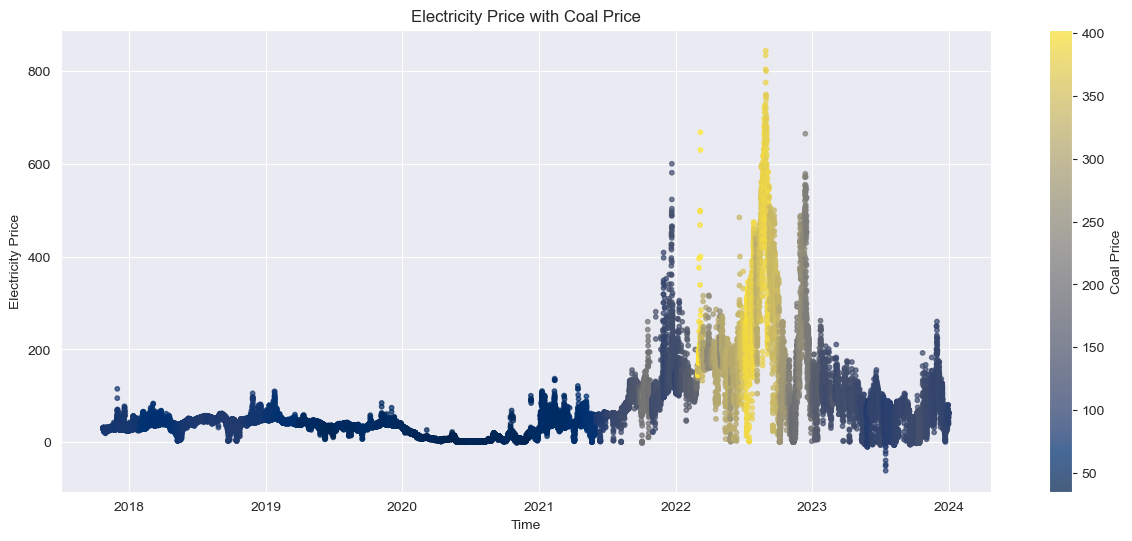

In [112]:
# Plotting the electricity price with the coal price
plt.figure(figsize=(15, 6))
scatter = plt.scatter(
    merged_df['time'], 
    merged_df['actual_price'], 
    c=merged_df['coal_price_euro'],  
    cmap='cividis',            
    s=10,                  
    alpha=0.7             
)

cbar = plt.colorbar(scatter)
cbar.set_label('Coal Price')
plt.title('Electricity Price with Coal Price')
plt.xlabel('Time')
plt.ylabel('Electricity Price')
plt.grid(True)
plt.show()


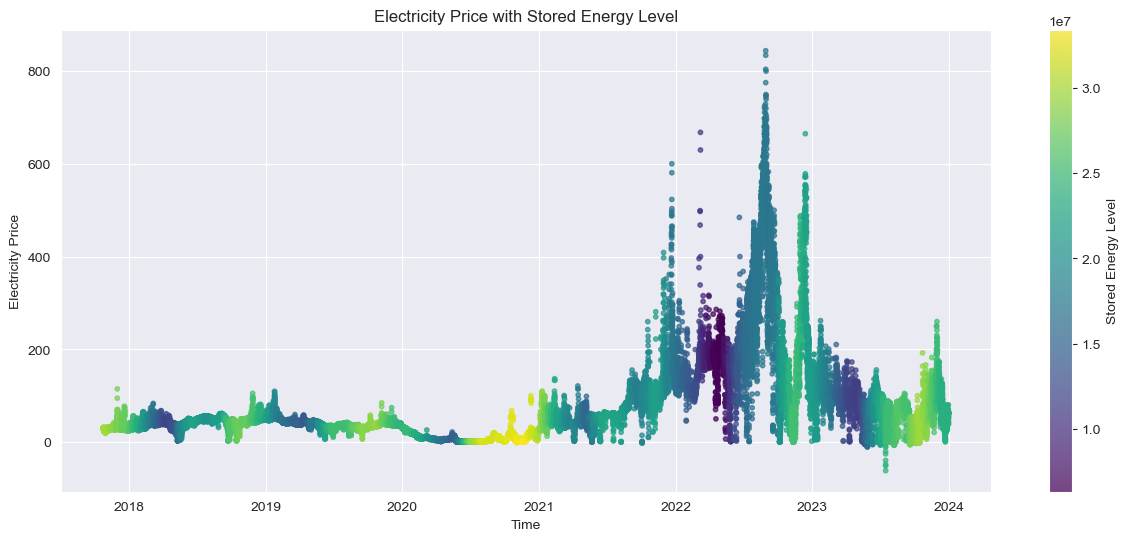

In [113]:
# Plotting the electricity price with the stored energy level
plt.figure(figsize=(15, 6))
scatter = plt.scatter(
    merged_df['time'], 
    merged_df['actual_price'], 
    c=merged_df['Stored_Energy_Value'],  
    cmap='viridis',                     
    s=10,                            
    alpha=0.7
)

cbar = plt.colorbar(scatter)
cbar.set_label('Stored Energy Level')
plt.title('Electricity Price with Stored Energy Level')
plt.xlabel('Time')
plt.ylabel('Electricity Price')
plt.grid(True)
plt.show()


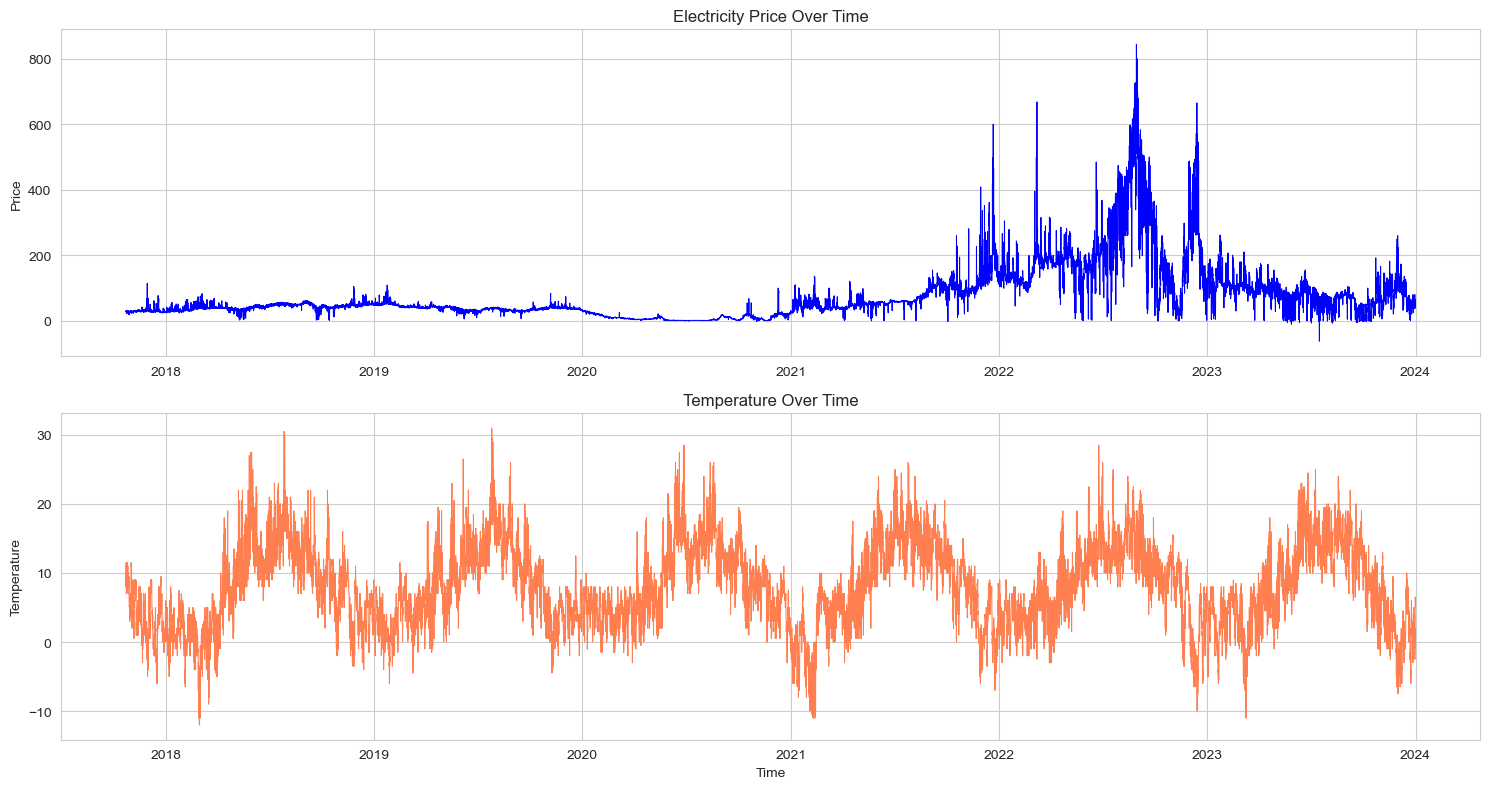

In [114]:
sns.set_style("whitegrid")
plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(merged_df['time'], merged_df['actual_price'], color='blue', linewidth=0.75)
plt.title('Electricity Price Over Time')
plt.ylabel('Price')

plt.subplot(2, 1, 2)
plt.plot(merged_df['time'], merged_df['temp_no2'], color='coral', linewidth=0.75)
plt.title('Temperature Over Time')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.tight_layout()
plt.show()


### Correlation Matrix

In [115]:
#find the correlation between dxy, oil, gas and coal prices
correlation = merged_df[['dxy_price', 'oil_price_euro', 'coal_price_euro', 'gas_price']].corr()
correlation

dxy_price  oil_price_euro  coal_price_euro  gas_price
dxy_price         1.000000        0.604694         0.610164   0.578640
oil_price_euro    0.604694        1.000000         0.845069   0.738820
coal_price_euro   0.610164        0.845069         1.000000   0.924709
gas_price         0.578640        0.738820         0.924709   1.000000

In [116]:
#Plotting the correlation matrix
cor= merged_df.corr()
cor

time  oil_price_euro  coal_price_euro  \
time                 1.000000    5.340565e-01     5.251553e-01   
oil_price_euro       0.534057    1.000000e+00     8.450693e-01   
coal_price_euro      0.525155    8.450693e-01     1.000000e+00   
Stored_Energy_Value -0.180283   -4.595787e-01    -4.701688e-01   
gas_price            0.508830    7.388204e-01     9.247085e-01   
dxy_price            0.631567    6.046941e-01     6.101644e-01   
Consumption         -0.079312   -1.384050e-01    -1.474482e-01   
Production           0.042915   -1.155117e-01    -9.597733e-02   
precipitation       -0.007384   -1.471100e-02    -2.130025e-02   
load_no2            -0.121431   -1.987675e-01    -1.907851e-01   
actual_price         0.445916    6.519329e-01     8.178912e-01   
wind_no2             0.370446    1.784133e-01     2.048922e-01   
temp_no2             0.058776    1.048828e-01     1.130644e-01   
system_price         0.329609    5.025376e-01     6.236880e-01   
hour                 0.000442   -4.437455e-16    -1.459609e-15   
day                  0.005998   -2.136296e-03    -1.170379e-03   
day_of_week          0.003064    2.367203e-03    -2.100829e-03   
month                0.082950    3.005409e-02     7.215224e-02   
year                 0.986576    5.294723e-01     5.135852e-01   
week                 0.081828    1.664971e-02     6.233226e-02   

                     Stored_Energy_Value     gas_price     dxy_price  \
time                       -1.802835e-01  5.088304e-01  6.315672e-01   
oil_price_euro             -4.595787e-01  7.388204e-01  6.046941e-01   
coal_price_euro            -4.701688e-01  9.247085e-01  6.101644e-01   
Stored_Energy_Value         1.000000e+00 -3.826412e-01 -1.890249e-01   
gas_price                  -3.826412e-01  1.000000e+00  5.786400e-01   
dxy_price                  -1.890249e-01  5.786400e-01  1.000000e+00   
Consumption                 6.448405e-03 -7.792003e-02 -1.798605e-01   
Production                  1.188528e-01 -3.875658e-02 -1.451701e-01   
precipitation               9.447589e-02 -1.452526e-02  2.609686e-03   
load_no2                   -1.212538e-02 -1.234039e-01 -2.921783e-01   
actual_price               -4.038698e-01  8.855820e-01  5.092611e-01   
wind_no2                   -2.078809e-02  2.374701e-01  1.939399e-01   
temp_no2                    8.568798e-02  6.443026e-02  1.068497e-01   
system_price               -3.411138e-01  6.864975e-01  3.554649e-01   
hour                        1.024991e-16 -1.500494e-15  9.049440e-16   
day                         1.151015e-02 -2.567566e-03  3.502223e-03   
day_of_week                 1.608540e-15 -1.721395e-03  1.702701e-03   
month                       5.274591e-01  1.388702e-01  1.705932e-01   
year                       -2.668635e-01  4.862812e-01  6.040036e-01   
week                        5.379032e-01  1.315433e-01  1.625305e-01   

                     Consumption  Production  precipitation  load_no2  \
time                   -0.079312    0.042915      -0.007384 -0.121431   
oil_price_euro         -0.138405   -0.115512      -0.014711 -0.198767   
coal_price_euro        -0.147448   -0.095977      -0.021300 -0.190785   
Stored_Energy_Value     0.006448    0.118853       0.094476 -0.012125   
gas_price              -0.077920   -0.038757      -0.014525 -0.123404   
dxy_price              -0.179860   -0.145170       0.002610 -0.292178   
Consumption             1.000000    0.754108      -0.017291  0.957989   
Production              0.754108    1.000000      -0.051870  0.745146   
precipitation          -0.017291   -0.051870       1.000000 -0.022732   
load_no2                0.957989    0.745146      -0.022732  1.000000   
actual_price           -0.017281    0.063109      -0.049818 -0.052631   
wind_no2                0.160180    0.038752       0.126822  0.120655   
temp_no2               -0.773096   -0.476727       0.039075 -0.737862   
system_price            0.129019    0.229250      -0.062705  0.095131   
hour                    0.1125

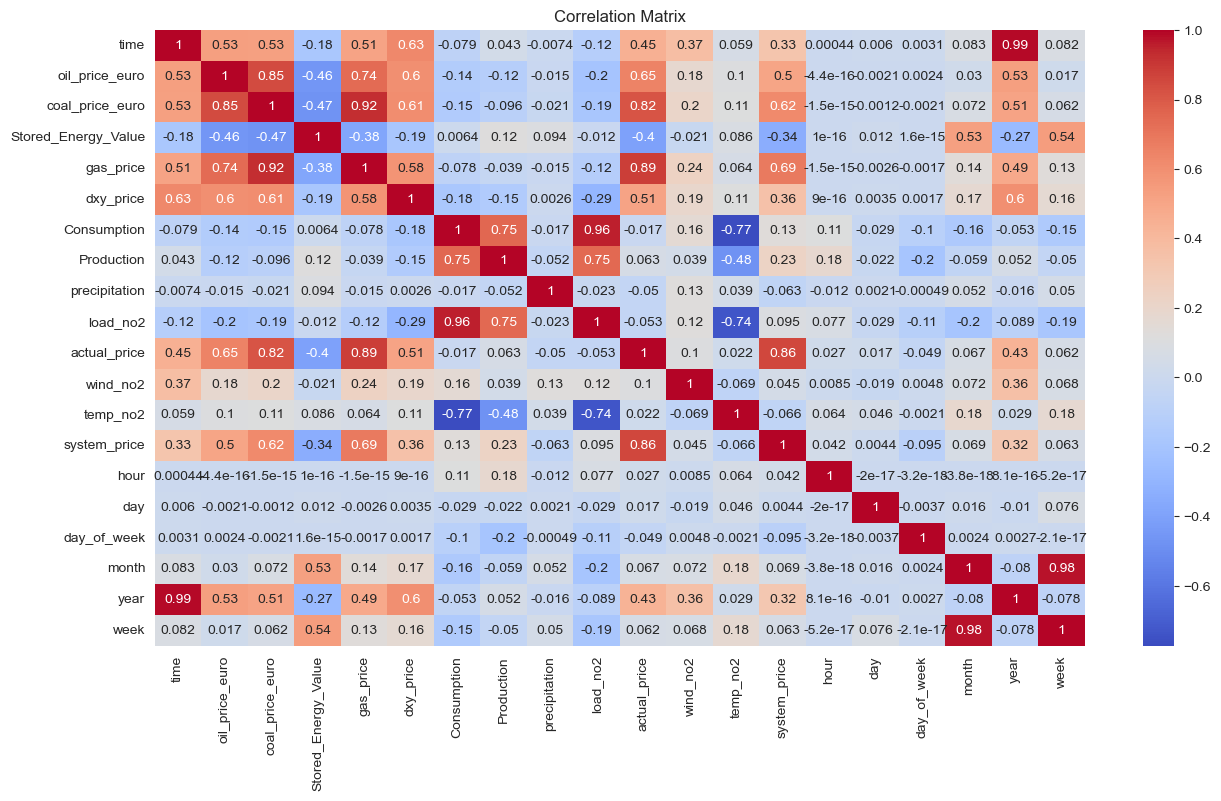

In [117]:
#Plot the correlation matrix
plt.figure(figsize=(15, 8))
sns.heatmap(cor, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

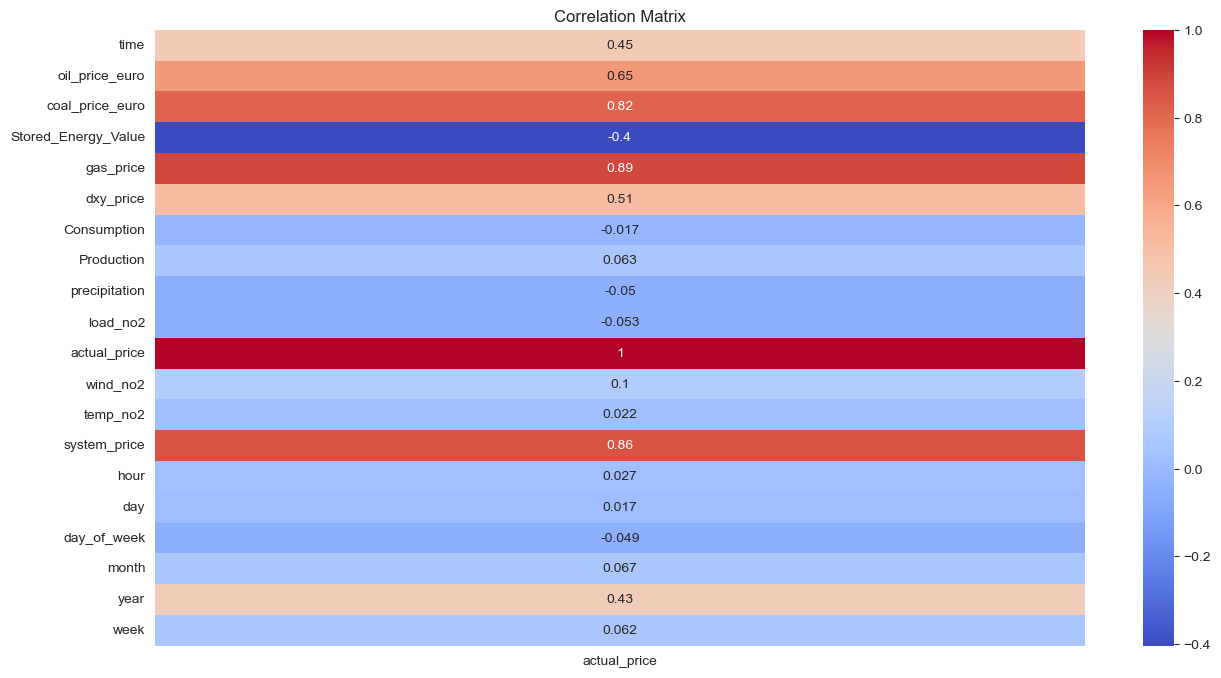

In [118]:
#plot the correlation matrix for actual_price column
plt.figure(figsize=(15, 8))
sns.heatmap(cor[['actual_price']], annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

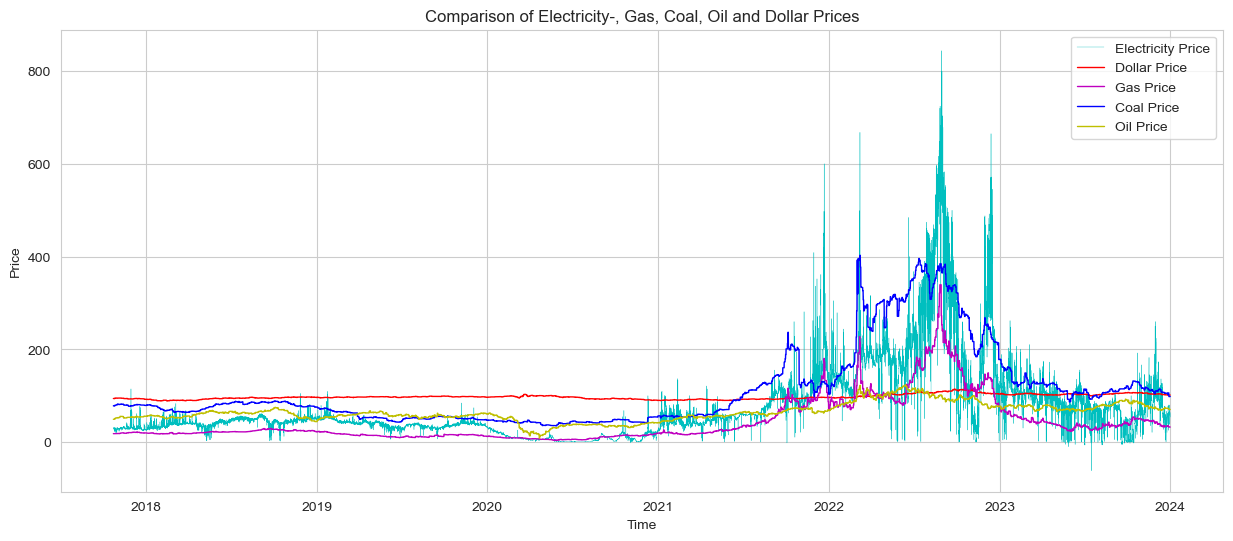

In [119]:
# plot the actual_price, dxy_price, gas_price, coal_price and oil_price over time 
plt.figure(figsize=(15, 6))
plt.plot(merged_df['time'], merged_df['actual_price'], color='c', linewidth=0.25, label='Electricity Price')
plt.plot(merged_df['time'], merged_df['dxy_price'], color='r', linewidth=1, label='Dollar Price')
plt.plot(merged_df['time'], merged_df['gas_price'], color='m', linewidth=1, label='Gas Price')
plt.plot(merged_df['time'], merged_df['coal_price_euro'], color='b', linewidth=1, label='Coal Price')
plt.plot(merged_df['time'], merged_df['oil_price_euro'], color='y', linewidth=1, label='Oil Price')
plt.title('Comparison of Electricity-, Gas, Coal, Oil and Dollar Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## Plotting Actual price with Temperature, Wind Speed, Total Load and Precipitation

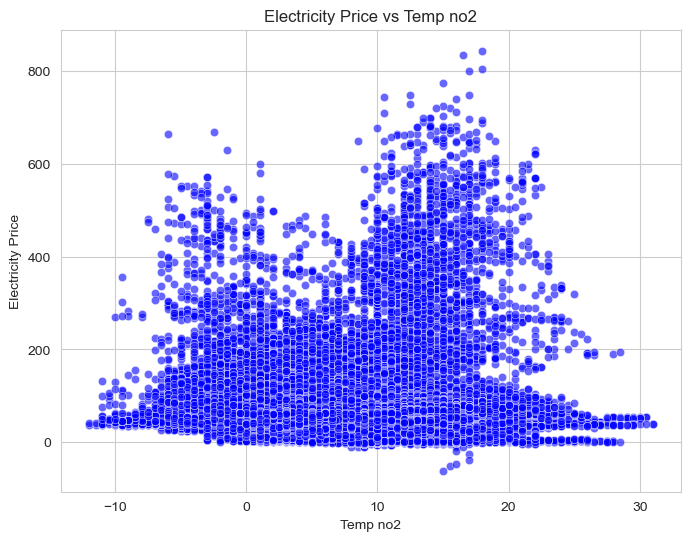

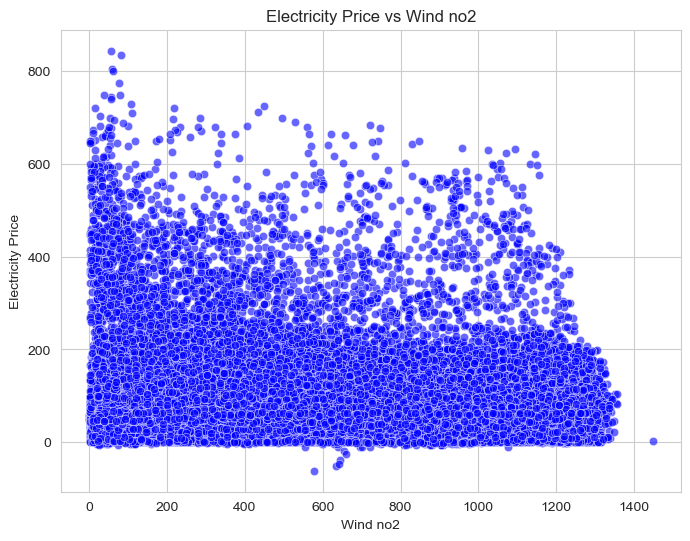

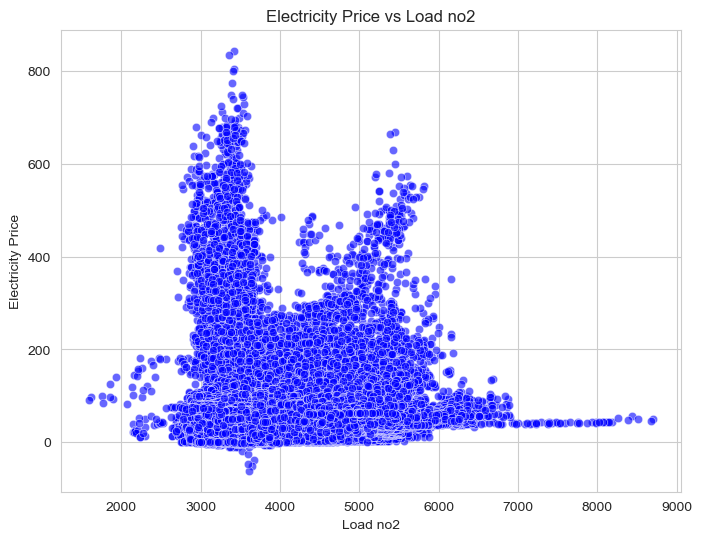

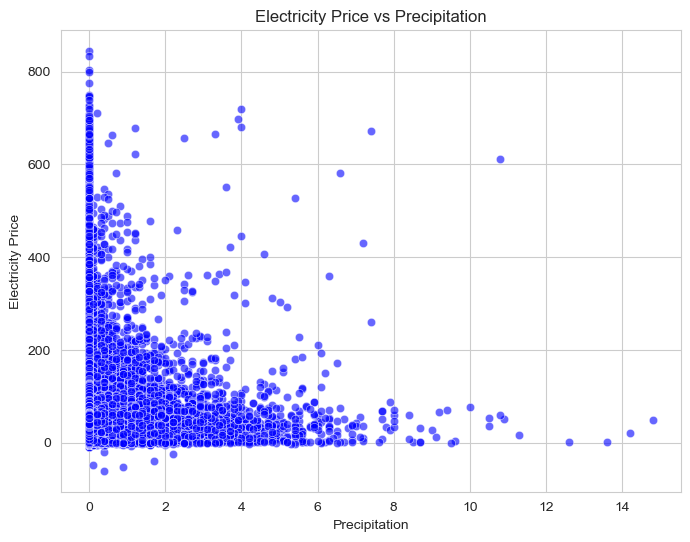

In [120]:
features = ['temp_no2', 'wind_no2', 'load_no2', 'precipitation']

for feature in features:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=feature, y='actual_price', data=merged_df, alpha=0.6, color='blue')
    plt.title(f'Electricity Price vs {feature.replace("_", " ").capitalize()}')
    plt.xlabel(feature.replace("_", " ").capitalize())
    plt.ylabel('Electricity Price')
    plt.grid(True)
    plt.show()
